In [59]:
# Standard Imports
import pandas as pd
import numpy as np
import os
#import MMV_Tools as mmv
import statsmodels.api as sm
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (12, 8)
import seaborn as sns
# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
# Classifcation metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import accuracy_score
# Feature Selection
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestRegressor
# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# Forecast Packages
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#Oversampling
from imblearn.over_sampling import RandomOverSampler
from time import time

In [2]:
# Classify Predictions under Confusion Matrix conponents
# True Positive or Negative (TP, TN) or False Positive or Negative (FP,FN)
def CMseries(df):
    if df["Pred"] == df["Pass"]:
        # prediction is correct
        if df["Pred"] == 1:
            return "TP"
        if df["Pred"] == 0:
            return "TN"
    if df["Pred"] != df["Pass"]:
        # prediction is wrong
        if df["Pred"] == 1:
            return "FP"
        if df["Pred"] == 0:
            return "FN"

In [3]:
# lets solve for how many students who fail each course will continue next semester
def failStat(df1,df2):
    s1 = df1.Period.iloc[0]
    s2 = df2.Period.iloc[0]
    c0 = []
    c1 = []
    c2 = []
    c3 = []
    c4 = []
    c5 = []
    c6 = []
    c7 = []
    c8 = []
    
    crs = ["DifCal","IntCal","VecCal","DifEqs"]
    for i in crs:
        en = df1[(df1["CrsEn"] == i)]
        c0.append(len(en))
        # those that pass DC
        dcp = df1[(df1["CrsEn"] == i) & (df1["Pass"] == 1)]
        c1.append(len(dcp))
        # Those that failed and are eligible to retake it
        dcf = df1[(df1["CrsEn"] == i) & (df1["Pass"] == 0) & (df1["RepEn"] < 2)]
        c2.append(len(dcf))
        # those that took DC the next semester
        dcpp = df2[df2["CrsEn"] == i]
        c3.append(len(dcpp))
        #DC repeaters
        dcrp = dcpp[dcpp["RepEn"] > 0]
        c4.append(len(dcrp))
        # DC retention
        dcret = dcrp[dcrp.studentID.isin(dcf.studentID)]
        c5.append(len(dcret))
        # DC readmittance
        dcrad = dcrp[~dcrp.studentID.isin(dcf.studentID)]
        c6.append(len(dcrad))
        # DC dropouts
        dcdrp = dcf[~dcf.studentID.isin(dcret.studentID)]
        c7.append(len(dcdrp))
        # Students kicked out due to multiple failures
        dcko = df1[(df1["CrsEn"] == i) & (df1["Pass"] == 0) & (df1["RepEn"] == 2)]
        c8.append(len(dcko))
        
    results = pd.DataFrame()
    results["CrsEn"] = crs
    results["S1"] = s1
    results["S1_Enrolled"] = c0
    results["S1_Pass"] = c1
    results["S1_Fail_Rel"] = c2
    results["KickOut"] = c8
    results["S2"] = s2
    results["S2_Enrolled"] = c3
    results["Repeat"] = c4
    results["Retention"] = c5
    results["Readmittance"] = c6
    results["Dropout"] = c7
    results["FirstTime"] = results.S2_Enrolled - results.Repeat
    
    return results

In [4]:
def fstat(periods,df):
    frames = []
    for i in range(len(periods) -1):
        df1 = df[df["Period"] == periods[i]]
        df2 = df[df["Period"] == periods[i+1]]
        df3 = failStat(df1,df2)
        frames.append(df3)
    
    result = pd.concat(frames)
    result1 = result.reset_index()
    
    return result1

In [5]:
# lets solve for how many students who Pass their class will continue next semester
def PassStat(df1,df2):
    # Caputre the periods of each datafame
    s1 = df1.Period.iloc[0]
    s2 = df2.Period.iloc[0]
    # store values for each column
    c0 = []
    c1 = []
    c2 = []
    c3 = []
    c4 = []
    c5 = []
    c6 = []
    c8 = []
    c7 = []
    
    # For loop to calcluate the firstime takers, retention, and drop out
    crs = ["DifCal","IntCal","VecCal","DifEqs"]
    j = 1
    for i in crs:
        # DifCal enrollement is only based on its on fail rates and new students not passes
        # no need to measure DifEqs b\c its the last class in the sequence
        if i == "DifEqs":
            pass
        else:
            en = df1[(df1["CrsEn"] == i)].copy()
            c0.append(len(en))
            # Looking at all the students that passed lower order class in sem1
            spass = df1[(df1["CrsEn"] == i) & (df1["Pass"] == 1)]
            c1.append(len(spass))
            # Look at the number of students enrolled in next order class the next semester
            sen = df2[df2["CrsEn"] == crs[j]]
            c2.append(len(sen))
            # How many that passed took it the following semester
            # Pass retention
            sret = sen[sen.studentID.isin(spass.studentID)]
            c3.append(len(sret))
            # Id which students are taking it for the first time
            sen0 = sen[sen["RepEn"] == 0]
            c4.append(len(sen0))
            # Id those who are taking for the first time but were not enrolled the semester before
            # This is a mixture of Readmittance and Transfer Students
            strad = sen0[~sen0.studentID.isin(sret.studentID)]
            c5.append(len(strad))
            # Readmittances of failures from summer courses in sem2
            reps = [sret,strad]
            rep = pd.concat(reps)
            leftover = rep[~rep.studentID.isin(sen0.studentID)]
            c7.append(leftover)
            c8.append(len(leftover))
            # Last ID students that Passed the last semester but did not take it the following semester
            # Mixture between those that dropped out and those who passed but failed to meet double dependency
            sdrop = spass[~spass.studentID.isin(sret.studentID)]
            c6.append(len(sdrop))
            j += 1

               
    crs1 = ["IntCal","VecCal","DifEqs"]
    results = pd.DataFrame(index=[1,2,3])
    results["CrsEn"] = crs1
    results["S1_LowerOrder"] = c0
    results["S1"] = s1
    results["S1_PassInto"] = c1
    results["S2"] = s2
    results["S2_Enrolled"] = c2
    results["FirstTime"] = c4
    results["Retention"] = c3
    results["Readmittance"] = c5
    results["Dropout"] = c6
    results["SummerFails"] = c8
    
    return results

In [6]:
def pstat(periods,df):
    frames = []
    for i in range(len(periods) -1):
        df1 = df[df["Period"] == periods[i]]
        df2 = df[df["Period"] == periods[i+1]]
        df3 = PassStat(df1,df2)
        frames.append(df3)
    result = pd.concat(frames)
    result1 = result.reset_index()
    
    return result1

In [7]:
def predRes(fails,passIE):
    preds = np.zeros(4)
    for i in range(4):
        if i == 0:
            preds[i] = fails[i]
        else:
            preds[i] = fails[i] + passIE[i-1]

    return preds

In [8]:
def model_eval(test,yhat):
    # Add predictions to test data
    test["Pred"] = yhat
    # What was the actual passing rate for all classes in the test data
    print("Test Pass Mean:",round(test.Pass.mean(),2))
    # What was the predicted passing rate for all classes in the test data
    print("Prediction Pass Mean:",round(test.Pred.mean(),2))
    
    test = test.assign(CM=test.apply(CMseries, axis=1)).copy()
    # Examine the results looking at the Count Column
    testCM = test.groupby(by=["CM"]).sum()
    plt.bar(testCM.index,testCM.Count)
    plt.title("Test Results Confusion Matrix")
    plt.show();
    # remove students that were predicted to be kicked out from the rest of the pool
    ko = test[test["RepEn"] == 2]
    koPred = ko[ko["Pred"] == 0]
    koCM = ko.groupby(by=["CM"]).sum()
    plt.bar(koCM.index,koCM.Count)
    plt.title("RepEn = 2 Results Confusion Matrix")
    plt.show();
    pool = test[~test.studentID.isin(koPred.studentID)]

    # Inspect Difcal Results
    dc = pool[pool["CrsEn"] == "DifCal"]
    dcfail = dc[dc["Pred"] == 0]
    dcpass = dc[dc["Pred"] == 1]
    dcCM = dc.groupby(by=["CM"]).sum()
    plt.bar(dcCM.index,dcCM.Count)
    plt.title("Differential Calculus Results Confusion Matrix")
    plt.show();
    # Inspect IntCal
    ic = pool[pool["CrsEn"] == "IntCal"]
    icfail = ic[ic["Pred"] == 0]
    icpass = ic[ic["Pred"] == 1]
    icCM = ic.groupby(by=["CM"]).sum()
    plt.bar(icCM.index,icCM.Count)
    plt.title("Integral Calculus Results Confusion Matrix")
    plt.show();
    # VecCAl 
    vc = pool[pool["CrsEn"] == "VecCal"]
    vcfail = vc[vc["Pred"] == 0]
    # Need to remove students who are in IND and EAD as they do not take DifEqs
    IndEad = vc[(vc["Major"] == 25) | (vc["Major"] == 37)]
    vcpass = vc[vc["Pred"] == 1]
    vcpIE =  vcpass[~vcpass.studentID.isin(IndEad.studentID)]
    vcCM = vc.groupby(by=["CM"]).sum()
    plt.bar(vcCM.index,vcCM.Count)
    plt.title("Vectorial Calculus Results Confusion Matrix")
    plt.show();
    # DifEqs
    de = pool[pool["CrsEn"] == "DifEqs"]
    defail = de[de["Pred"] == 0]
    depass = de[de["Pred"] == 1]
    deCM = de.groupby(by=["CM"]).sum()
    plt.bar(deCM.index,deCM.Count)
    plt.title("Differential Equations Results Confusion Matrix")
    plt.show();

    plt.figure(figsize=(18,8))
    ax = sns.violinplot(x = "MajorT", y = "Pred", data = test)
    plt.title("Prediction Distribution by Major")
    plt.show()
    
    plt.figure(figsize=(18,8))
    ax = sns.violinplot(x = "MajorT", y = "Pass", data = test)
    plt.title("Actual Distribution by Major")
    plt.show()
    
    # raw pass and fails by classes
    raw_scores = test.groupby(by = ["CrsEn","Pred"]).sum()
    raw_scores = raw_scores[["Count","Pass","Fail"]]
                            
    dc1= test[test["CrsEn"] == "DifCal"]
    ic1 = test[test["CrsEn"] == "IntCal"]
    vc1 = test[test["CrsEn"] == "VecCal"]
    de1 = test[test["CrsEn"] == "DifEqs"]
    
    # Next Semster Pools
    passout = [len(dcpass),len(icpass),len(vcpass),len(depass)]
    passesIE = [0,len(dcpass),len(icpass),len(vcpass)]
    fails = [len(dcfail),len(icfail),len(vcfail),len(defail)]
    enrolled = [len(dc1),len(ic1),len(vc1), len(de1)]
    
    dct = len(test[(test["CrsEn"] == "DifCal") & (test["Pass"] == 1)])
    dctp = len(test[(test["CrsEn"] == "DifCal") & (test["CM"] == "TP")])
    dctn = len(test[(test["CrsEn"] == "DifCal") & (test["CM"] == "TN")])
    ict = len(test[(test["CrsEn"] == "IntCal") & (test["Pass"] == 1)])
    ictp = len(test[(test["CrsEn"] == "IntCal") & (test["CM"] == "TP")])
    ictn = len(test[(test["CrsEn"] == "IntCal") & (test["CM"] == "TN")])
    vct = len(test[(test["CrsEn"] == "VecCal") & (test["Pass"] == 1)])
    vctp = len(test[(test["CrsEn"] == "VecCal") & (test["CM"] == "TP")])
    vctn = len(test[(test["CrsEn"] == "VecCal") & (test["CM"] == "TN")])
    det = len(test[(test["CrsEn"] == "DifEqs") & (test["Pass"] == 1)])
    detp = len(test[(test["CrsEn"] == "DifEqs") & (test["CM"] == "TP")])
    detn = len(test[(test["CrsEn"] == "DifEqs") & (test["CM"] == "TN")])
    
    trues = [dct,ict,vct,det]
    truep = [dctp, ictp, vctp,detp]
    truen = [dctn, ictn, vctn,detn]
    
    results = pd.DataFrame(columns=["CrsEn","Enrolled1","PassOut",
                                    "PassIn","Fails","ValPass","ValFail",
                                   "TruePass","TrueFail",
                                   "FalsePass","FalseFail"])

    results["PassIn"] = passesIE
    results["Fails"] = fails
    results["CrsEn"] =["DifCal","IntCal","VecCal","DifEqs"]
    results["PassOut"] = passout
    results["Enrolled1"] = enrolled
    results["ValPass"] = trues
    results["ValFail"] = results.Enrolled1 - results.ValPass
    results["TruePass"] = truep
    results["TrueFail"] = truen
    results["FalsePass"] = abs(results.PassOut - results.TruePass)
    results["FalseFail"] = abs(results.Fails - results.TrueFail)
    
    return results,test

In [9]:
# Evaluate several ml models by training on training set and testing on testing set
# Binary Classification
def evaluate(X_train, X_test, y_train, y_test,fs):
    # Names of models
    model_name_list = ['Logistic Regression', 'Ridge Calssification',
                      'Random Forest', 'Decision Tree', 'SVC','NaiveBayes']

    # Instantiate the models
    model1 = LogisticRegression()
    model2 = RidgeClassifier()
    model3 = RandomForestClassifier()
    model4 = DecisionTreeClassifier()
    model5 = SVC()
    model6 = GaussianNB()
    
    # Dataframe for results
    results = pd.DataFrame(columns=["Acc","Precision", 'Recall',
                                    "Specificity","f1-score","Kappa","AUC",
                                   "TP","FP","TN","FN",
                                   "Pass","Fail"], index = model_name_list)
    # store predictions
    yhats = []
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4,model5,model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        yhats.append(predictions)
        acc = accuracy_score(y_test,predictions)
        tn, fp, fn, tp = CM(y_test, predictions).ravel()
        Precision = tp/(tp+fp) 
        Recall = tp/(tp+fn) 
        f1 = (2*Precision*Recall)/(Precision + Recall)
        Specificity = tn/(tn+fp)
        kappa = cohen_kappa_score(y_test, predictions)
        auc = roc_auc_score(y_test, predictions)
        total = len(y_test)
        passes = y_test.sum()
        fails = total - passes
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.ix[model_name, :] = [acc, Precision, Recall,Specificity,f1,kappa,auc,tp,fp,tn,fn,passes,fails]
        #ROC
        #y_pred_proba = model.predict_proba(X_test)
        #skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
        #plt.show()
    
    results["FeatSel"] = fs
    
    return results, yhats

In [10]:
def blClass(Xdata,Xtests,Ytrain,Ytest):
    import warnings
    warnings.filterwarnings("ignore")
    # Feature Selection Techniques
    fst = ["All","Chi-Square","F-Test","MI","RandomForest"]
    nfeats = []
    for i in range(len(fst)):
        n = len(Xdata[i].keys())
        nfeats.append(n)
        
    results = []
    for i in range(len(Xdata)):
        if i == 0:
            start = time()
            print("\nTarget Distribution Resampleing:")
            print("Training Targets:",Ytrain.value_counts())
            # Targets are highly unbalanced which will effect the confidence of the classifcation
            #RandomOverSampler
            #declare random sampler
            #use that random sample
            ros = RandomOverSampler(random_state = 42)
            X_train_over, Y_train_over = ros.fit_sample(Xdata[i], Ytrain)
            print("Oversampled Training Targets:",Y_train_over.value_counts())
            print("\nFeature Selction Meth:", fst[i],"with",nfeats[i])
            restable, yhats = evaluate(X_train_over, Xtests[i], Y_train_over, Ytest,fst[i])
            results.append(restable)
            print("Time:",time() - start)
        else:
            start = time()
            print("\nFeature Selction Meth:", fst[i],"with",nfeats[i])
            ros = RandomOverSampler(random_state = 42)
            X_train_over, Y_train_over = ros.fit_sample(Xdata[i], Ytrain)
            restable, yhats = evaluate(X_train_over, Xtests[i], Y_train_over, Ytest,fst[i])
            results.append(restable)
            print("Time:",time() - start)
            
    print("\nEND")
    return results     

In [11]:
# Evaluate several ml models by training on training set and testing on testing set
# Binary Classification
def evaluate2(X_train, X_test, y_train, y_test,fs):
    # Names of models
    model_name_list = ['Logistic Regression', 'Ridge Calssification',
                      'Random Forest', 'Decision Tree', 'SVC','NaiveBayes']

    # Instantiate the models
    model1 = LogisticRegression(C=0.001,solver="newton-cg")
    model2 = RidgeClassifier(alpha=0.1,fit_intercept=True,solver='lsqr',tol=1)
    model3 = RandomForestClassifier(min_samples_leaf=1,min_samples_split=10,n_estimators=1000)
    model4 = DecisionTreeClassifier(min_samples_leaf=1,min_samples_split=2)
    model5 = SVC(C=0.1)
    model6 = GaussianNB(var_smoothing=1e-10)
    
    # Dataframe for results
    results = pd.DataFrame(columns=["Acc","Precision", 'Recall',
                                    "Specificity","f1-score",
                                    "Kappa","AUC",
                                   "TP","FP","TN","FN",
                                   "Pass","Fail"], index = model_name_list)
    # store predictions
    yhats = []
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4,model5,model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        yhats.append(predictions)
        acc = accuracy_score(y_test,predictions)
        tn, fp, fn, tp = CM(y_test, predictions).ravel()
        Precision = tp/(tp+fp) 
        Recall = tp/(tp+fn) 
        f1 = (2*Precision*Recall)/(Precision + Recall)
        Specificity = tn/(tn+fp)
        kappa = cohen_kappa_score(y_test, predictions)
        auc = roc_auc_score(y_test, predictions)
        total = len(y_test)
        passes = y_test.sum()
        fails = total - passes
        
        # Insert results into the dataframeSpecificity,f1,kappa,auc
        model_name = model_name_list[i]
        results.ix[model_name, :] = [acc, Precision, Recall,Specificity,f1,kappa,auc,tp,fp,tn,fn,passes,fails]
        #ROC
        #y_pred_proba = model.predict_proba(X_test)
        #skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
        #plt.show()
    results["FetSel"] = fs
    return results, yhats

In [12]:
def modelComp(Xdata,Xtests,Ytrain,Ytest):
    import warnings
    warnings.filterwarnings("ignore")
    # Feature Selection Techniques
    fst = ["All","Chi-Square","F-Test","MI","RandomForest"]
    nfeats = []
    preds = []
    for i in range(len(fst)):
        n = len(Xdata[i].keys())
        nfeats.append(n)
        
    results = []
    for i in range(len(Xdata)):
        if i == 0:
            start = time()
            print("\nTarget Distribution Resampleing:")
            print("Training Targets:",Ytrain.value_counts())
            # Targets are highly unbalanced which will effect the confidence of the classifcation
            #RandomOverSampler
            #declare random sampler
            #use that random sample
            ros = RandomOverSampler(random_state = 42)
            X_train_over, Y_train_over = ros.fit_sample(Xdata[i], Ytrain)
            print("Oversampled Training Targets:",Y_train_over.value_counts())
            print("\nFeature Selction Meth:", fst[i],"with",nfeats[i])
            meth = fst[i]
            restable, yhats = evaluate2(X_train_over, Xtests[i], Y_train_over, Ytest,fst[i])
            results.append(restable)
            preds.append(yhats)
            print("Time:",time() - start)
        else:
            start = time()
            print("\nFeature Selction Meth:", fst[i],"with",nfeats[i])
            ros = RandomOverSampler(random_state = 42)
            X_train_over, Y_train_over = ros.fit_sample(Xdata[i], Ytrain)
            restable, yhats = evaluate2(X_train_over, Xtests[i], Y_train_over, Ytest,fst[i])
            results.append(restable)
            preds.append(yhats)
            print("Time:",time() - start)
            
    print("\nEND")
    return results,preds

In [13]:
def crspf(df1,df2):
    df1 = df1[["S1","S1_PassInto","Retention","Readmittance","SummerFails"]]
    df1 = df1.rename(columns={"S1_PassInto":"PassIn","Retention": "Pret", "Readmittance": "Prad"})
    
    df2 = df2[["CrsEn","S1_Enrolled","S1_Pass","S1_Fail_Rel","S2",
               "S2_Enrolled","Retention","Readmittance"]]
    df2 = df2.rename(columns={"S1_Enrolled":"Enrolled1","S1_Pass":"PassOut",
                              "S1_Fail_Rel":"Fail","S2_Enrolled":"Enrolled2",
                              "Retention":"Fret","Readmittance":"Frad"})
    
    df1.index = df1.S1
    df2.index = df1.index
    
    df3 = pd.concat((df1,df2),axis=1)
    df4 = df3[["Enrolled1","PassOut","PassIn","Fail",
              "S2","Enrolled2","Pret","Fret","Prad","Frad","SummerFails"]]
    
    return df4

In [14]:
def dfcrspf(passes,fails):
    frames = []
    for i in range(0,3):
        df = crspf(passes[i],fails[i])
        frames.append(df)
    intcal = frames[0]
    veccal = frames[1]
    difeqs = frames[2]
    
    return intcal,veccal,difeqs

In [15]:
# Holt-Winters Selection method to see if data is addative or multiplicative
def hw(train,test,period):
    fit1 = ExponentialSmoothing(train, seasonal_periods=period, trend='add', seasonal='add', damped=True).fit(
            use_boxcox=True)
    fit2 = ExponentialSmoothing(train, seasonal_periods=period, trend='add', seasonal='mul', damped=True).fit(
            use_boxcox=True)
    fit3 = ExponentialSmoothing(train, seasonal_periods=period, trend='mul', seasonal='add', damped=True).fit(
            use_boxcox=True)
    fit4 = ExponentialSmoothing(train, seasonal_periods=period, trend='mul', seasonal='mul', damped=True).fit(
            use_boxcox=True)

    print("Residual SSE:")
    print("1", fit1.sse)
    print("2", fit2.sse)
    print("3", fit3.sse)
    print("4", fit4.sse)

     # fitted values
    ff1 = fit1.fittedvalues
    ff2 = fit2.fittedvalues
    ff3 = fit3.fittedvalues
    ff4 = fit4.fittedvalues

     # forecast errors
    fc1 = fit1.forecast(len(test))
    e1 = test - fc1
    fc2 = fit2.forecast(len(test))
    e2 = test - fc2
    fc3 = fit3.forecast(len(test))
    e3 = test - fc3
    fc4 = fit4.forecast(len(test))
    e4 = test - fc4



In [16]:
# Run Holt Winters on desired set and custom parameters
def hwp(train,test,period,trend,seas):
    fit1 = ExponentialSmoothing(train, seasonal_periods=period, trend=trend, seasonal= seas, damped=True).fit(
            use_boxcox=True)
    ffit = fit1.fittedvalues
    fc1 = fit1.forecast(len(test))
    forecast = np.append(ffit,fc1)
    return forecast

# Load Data

In [17]:
df = pd.read_csv("ITCH_IntroMathAcademicData.csv")
df_master = df.copy()
df_master

,studentID,Major,MajorT,Year,Semester,CrsEn,Order,Grade,SGrade,Pass,Fail,Count,Instructor,RepEn,MethEn,Group,Period
0,12060799,19,CHM,2012,3,DifCal,1,0,69,0,1,1,LIMAS FRESCAS BLANCA ROSA,0,Complementary,A,20123
1,12060799,19,CHM,2013,1,DifCal,1,71,71,1,0,1,CERECERES ARVIZO CESAR AUGUSTO,1,Ordinary,H,20131
2,12060799,19,CHM,2013,3,IntCal,2,0,69,0,1,1,AGUIRRE PARRES AMALIA CONCEPCION,0,Complementary,B,20133
3,12060799,19,CHM,2014,3,IntCal,2,78,78,1,0,1,DIAZ PEÑA MIREYA ARMIDA,1,Ordinary,F,20143
4,12060799,19,CHM,2015,1,VecCal,3,0,69,0,1,1,LIMAS FRESCAS BLANCA ROSA,0,Complementary,C,20151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14944,C17061218,23,MEC,2019,3,DifEqs,4,92,92,1,0,1,MANZANERA QUINTANA MARIA ISABEL,0,Complementary,C,20193
14945,C17061274,23,MEC,2019,3,VecCal,3,76,76,1,0,1,MANZANERA QUINTANA MARIA ISABEL,0,Complementary,F,20193
14946,C17061304,23,MEC,2019,3,VecCal,3,75,75,1,0,1,CABRALES ROSALES YOLANDA,0,Complementary,C,20193
14947,C18060045,23,MEC,2019,3,DifCal,1,0,69,0,1,1,VALDIVIEZO ROMAN FRANCISCO RAUL,0,Complementary,F,20193


## Split data into test and training sets

In [18]:
# only used to validate the true number of students not for classification
validation = df[df["Period"] == 20193].copy()

In [19]:
# training set
data = df[df["Period"] < 20193].copy()

In [20]:
# This will be the test data for classifcation to predict the number students in each chort
test = data[data["Period"] == 20191].copy()

In [21]:
# training data for classification
train = data[~data.isin(test)].copy()

## Convert data into one-hot encoding

In [22]:
# Select only categorical variables
# Remove studentID and othere variables that are not representative of the data or are encoded in other varibles
# Will hep with reducing the number of columns/features and avoid a sparse matrix
df1 = df.copy()
df1 = df.drop(columns=["studentID","Period","Year","Major","Grade","Count","MethEn"]).copy()
category_df = df1.select_dtypes('object')
# One hot encode the variables
dummy_df = pd.get_dummies(category_df)
# Put some of the numeric featues in the dataframe
dummy_df["Pass"] = df["Pass"]
dummy_df["RepEn"] = df["RepEn"]
dummy_df["Semester"]= df["Semester"]
dummy_df["Period"] = df["Period"]
dummy_df

,MajorT_CHM,MajorT_EAD,MajorT_ELC,MajorT_ELT,MajorT_EME,MajorT_IND,MajorT_MAT,MajorT_MEC,CrsEn_DifCal,CrsEn_DifEqs,...,Group_U,Group_V,Group_W,Group_X,Group_Y,Group_Z,Pass,RepEn,Semester,Period
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3,20123
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,1,20131
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,20133
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,3,20143
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,20151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14944,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,3,20193
14945,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,3,20193
14946,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,3,20193
14947,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,3,20193


In [23]:
#Split into training/testing sets with 20% split
dummyTest = dummy_df[dummy_df["Period"] == 20191]
dummyTest = dummyTest.drop(columns="Period")
Ytest = dummyTest["Pass"]
Xtest = dummyTest.drop(columns=["Pass"])

In [24]:
# get the training data in onehot encoding
data = dummy_df[~dummy_df.isin(test)]

In [25]:
data = data.dropna()

In [26]:
data = data.drop(columns=["Period"])

In [27]:
Ytrain = data["Pass"]
Xtrain = data.drop(columns=["Pass"])

## Feature Selction 

In [28]:
chi2_score, chi_2_p_value = chi2(Xtrain,Ytrain)
f_score, f_p_value = f_classif(Xtrain,Ytrain)
mut_info_score = mutual_info_classif(Xtrain,Ytrain)

In [29]:
FeatSelc = pd.DataFrame()
FeatSelc["Feat"] = Xtrain.keys()
FeatSelc["ch2Pval"] = chi_2_p_value
FeatSelc["FscorePval"] = f_p_value
FeatSelc["MI_score"] = mut_info_score

In [30]:
FeatSelc.describe()

,ch2Pval,FscorePval,MI_score
count,9.100000e+01,9.100000e+01,91.000000
mean,1.399625e-01,1.376676e-01,0.002273
std,2.305411e-01,2.288297e-01,0.003059
min,3.349559e-57,3.754719e-60,0.000000
25%,2.022452e-05,1.408263e-05,0.000000
50%,6.243479e-03,6.081188e-03,0.000188
75%,1.684605e-01,1.661808e-01,0.004093
max,8.215896e-01,8.212152e-01,0.012323


In [31]:
# Create a list data Xtraining sets with different # features based of the various methods
Xdata = []
Xdata.append(Xtrain)
Xtests = []
Xtests.append(Xtest)

Number of Features that pass Chi-Square Test: 49


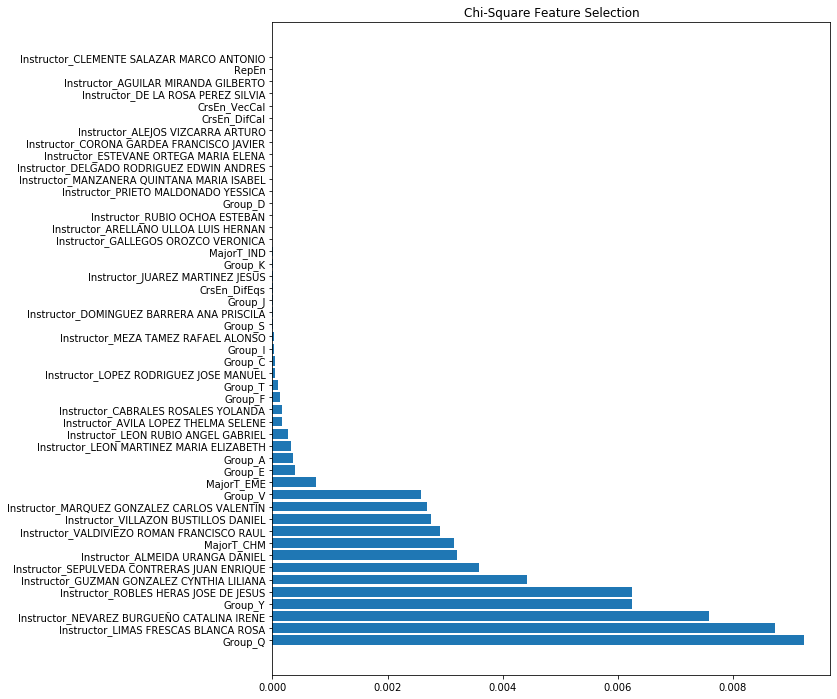

In [32]:
ch2 = FeatSelc[FeatSelc["ch2Pval"] < 0.01 ].sort_values(by="ch2Pval",ascending = False)
print("Number of Features that pass Chi-Square Test:", len(ch2))
ch2Xtrain = Xtrain[ch2.Feat]
ch2Xtest = Xtest[ch2.Feat]
Xdata.append(ch2Xtrain)
Xtests.append(ch2Xtest)
plt.figure(figsize=(10,12))
plt.barh(ch2.Feat,ch2.ch2Pval)
plt.title("Chi-Square Feature Selection");

Number of Features that pass F-Test: 50


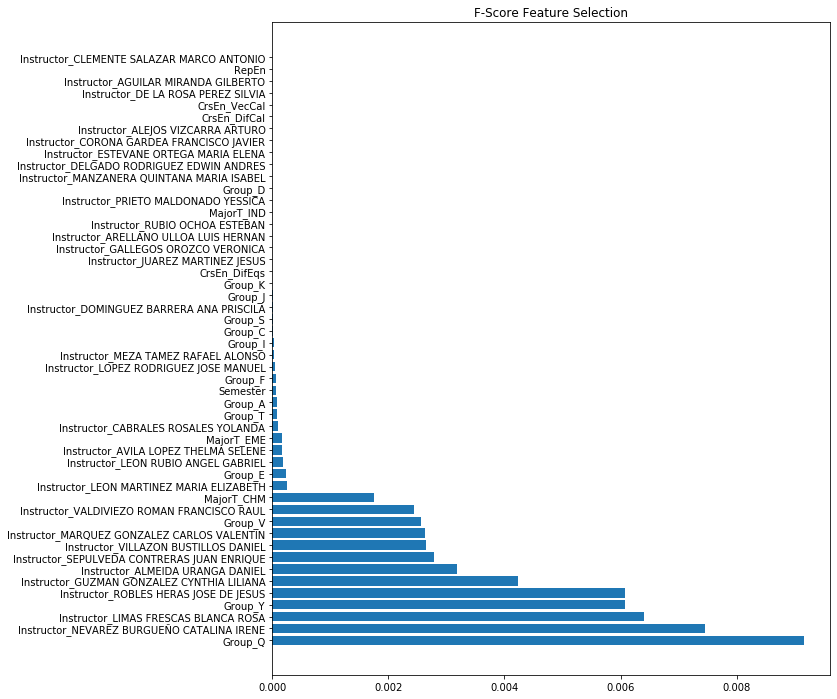

In [33]:
Fs = FeatSelc[FeatSelc["FscorePval"] < 0.01 ].sort_values(by="FscorePval",ascending = False)
print("Number of Features that pass F-Test:", len(Fs))
FXtrain = Xtrain[Fs.Feat]
FXtest = Xtest[Fs.Feat]
Xdata.append(FXtrain)
Xtests.append(FXtest)
plt.figure(figsize=(10,12))
plt.barh(Fs.Feat,Fs.FscorePval)
plt.title("F-Score Feature Selection");

Number of Features with MI Scorre > 0: 42


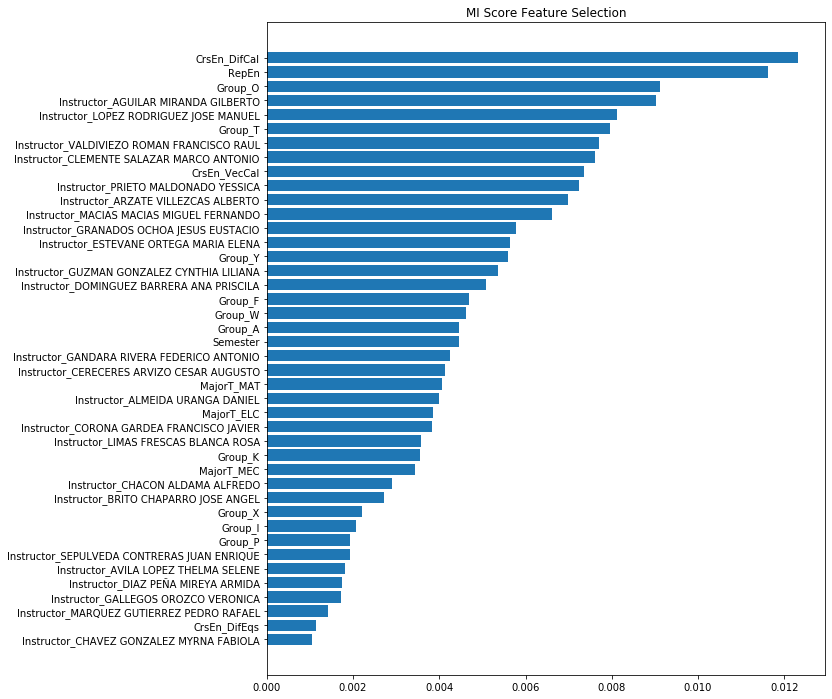

In [34]:
MI = FeatSelc[FeatSelc["MI_score"] > 0.001 ].sort_values(by="MI_score",ascending = True)
print("Number of Features with MI Scorre > 0:", len(MI))
MIXtrain = Xtrain[MI.Feat]
MIXtest = Xtest[MI.Feat]
Xdata.append(MIXtrain)
Xtests.append(MIXtest)
plt.figure(figsize=(10,12))
plt.barh(MI.Feat,MI.MI_score)
plt.title("MI Score Feature Selection");

In [35]:
# Use RandomForest to estimate Feature Importance
X = Xtrain
Y = Ytrain
feat_names = Xtrain.keys()
rf = RandomForestRegressor()
rf.fit(X, Y)
rffi = pd.DataFrame()
rffi["Feat"] = feat_names
rffi["Importance"] =rf.feature_importances_

Number of Features > 0 Random Forest Regressor: 30
0.02644541037464216


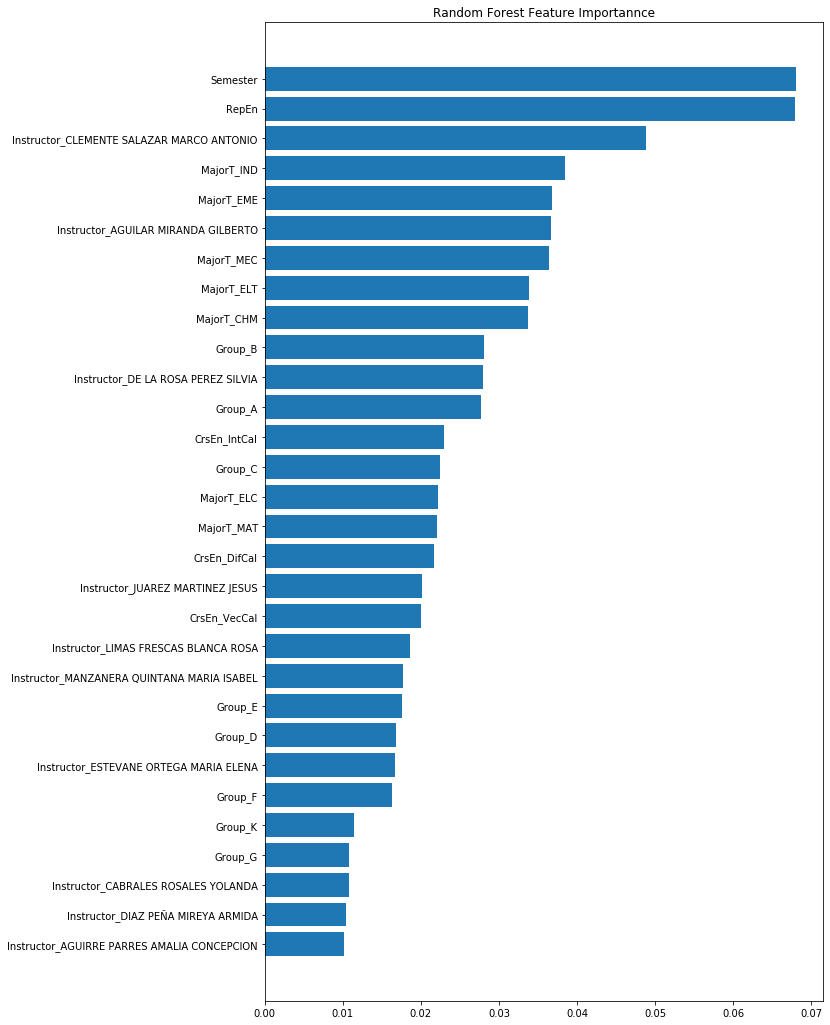

In [36]:
rffia = rffi[rffi["Importance"] > 0.01].sort_values(by="Importance",ascending = True)
print("Number of Features > 0 Random Forest Regressor:", len(rffia))
print(rffia.Importance.mean())
RFXtrain = Xtrain[rffia.Feat]
RFXtest = Xtest[rffia.Feat]
Xdata.append(RFXtrain)
Xtests.append(RFXtest)
plt.figure(figsize=(10,18))
plt.barh(rffia.Feat,rffia.Importance)
plt.title("Random Forest Feature Importannce");

In [37]:
# Overall the several methods Reduced the initail features of 91
# Ch2 and F-test reduced to 49 & 50  with 99% confidence
# MI had 39 with MI > 0.001 
# RF had 31 > 0.01
# There is overalp in feature importance across the methods
# There is variance in the ranking of each feature
#ch2:0,F:1,MI:2,RF:3
print(len(Xdata))
print(len(Xtests))

5
5


## Baseline Classifcation Models

In [38]:
# Train and test data on 6 classifiers on 5 different datasets from feature selection
cmodels_bl = blClass(Xdata,Xtests,Ytrain,Ytest)


Target Distribution Resampleing:
Training Targets: 1.0    8955
0.0    4096
Name: Pass, dtype: int64
Oversampled Training Targets: 1.0    8955
0.0    8955
Name: Pass, dtype: int64

Feature Selction Meth: All with 91
Time: 43.235373735427856

Feature Selction Meth: Chi-Square with 49
Time: 24.407601833343506

Feature Selction Meth: F-Test with 50
Time: 25.115235090255737

Feature Selction Meth: MI with 42
Time: 18.541521787643433

Feature Selction Meth: RandomForest with 30
Time: 14.686187744140625

END


In [39]:
# Classification results
cmodels_bl

[                           Acc Precision    Recall Specificity  f1-score  \
 Logistic Regression   0.632244  0.666094  0.715207    0.521525  0.689778   
 Ridge Calssification  0.624868  0.661752  0.703226    0.520295  0.681859   
 Random Forest         0.632244  0.668996  0.705991    0.533825  0.686996   
 Decision Tree         0.607482  0.651786  0.672811    0.520295  0.662132   
 SVC                   0.669125  0.707539  0.717972    0.603936  0.712717   
 NaiveBayes            0.477871  0.783133  0.119816     0.95572  0.207834   
 
                          Kappa       AUC   TP   FP   TN   FN  Pass Fail  \
 Logistic Regression   0.239689  0.618366  776  389  424  309  1085  813   
 Ridge Calssification  0.225889  0.611761  763  390  423  322  1085  813   
 Random Forest         0.242055  0.619908  766  379  434  319  1085  813   
 Decision Tree         0.194154  0.596553  730  390  423  355  1085  813   
 SVC                   0.322704  0.660954  779  322  491  306  1085  813   
 Na

## Grid-Search and Hyperparameter tuning

In [40]:
#Based upon the baseline models, the classifiers do best on the RandomForest Feature Selection
# The two top models are SVC and Naive Bays with highest accuarcy and Recall

In [41]:
clfs = {'lr': LogisticRegression(random_state=42),
        'rr': RidgeClassifier(random_state=42),
        'dt': DecisionTreeClassifier(random_state=42),
        'rf': RandomForestClassifier(random_state=42),
        'gnb': GaussianNB()}

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe_clfs = {}

for name, clf in clfs.items():
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), ('clf', clf)])

In [43]:
param_grids = {}

In [44]:
# Paramters for Logistic Regression

param_grid = [{'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               'clf__C': [100,10,1.0,0.1,0.01,0.001,0.0001]}]
              
param_grids['lr'] = param_grid

In [45]:
# Ridge Classifier regression

param_grid = [{'clf__alpha': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
               'clf__fit_intercept': [True, False],
               'clf__tol': [0.1, 1],
               'clf__solver': ['auto', 'svd', 'cholesky', 'lsqr',
                               'sparse_cg', 'sag', 'saga']}]

param_grids["rr"] = param_grid

In [46]:
# Prameters for Decision Tree

param_grid = [{'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]
param_grids['dt'] = param_grid

In [47]:
# Paramters for Random Forest
param_grid = [{'clf__n_estimators': [2, 10, 30,50,100,1000],
              'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]

param_grids['rf'] = param_grid

In [48]:
# Parameters for Naive Bayes
param_grid = [{'clf__var_smoothing': [10 ** i for i in range(-10, -7)]}]

param_grids['gnb'] = param_grid

In [49]:
param_grids

{'lr': [{'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
   'clf__C': [100, 10, 1.0, 0.1, 0.01, 0.001, 0.0001]}],
 'rr': [{'clf__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
   'clf__fit_intercept': [True, False],
   'clf__tol': [0.1, 1],
   'clf__solver': ['auto',
    'svd',
    'cholesky',
    'lsqr',
    'sparse_cg',
    'sag',
    'saga']}],
 'dt': [{'clf__min_samples_split': [2, 10, 30],
   'clf__min_samples_leaf': [1, 10, 30]}],
 'rf': [{'clf__n_estimators': [2, 10, 30, 50, 100, 1000],
   'clf__min_samples_split': [2, 10, 30],
   'clf__min_samples_leaf': [1, 10, 30]}],
 'gnb': [{'clf__var_smoothing': [1e-10, 1e-09, 1e-08]}]}

In [50]:
# Apply grid-search on the random forest dataset
xd = Xdata[4]

In [51]:
# Apply random oversampler to balance target data
ros = RandomOverSampler(random_state = 42)
X_train_over, Y_train_over = ros.fit_sample(Xdata[3], Ytrain)

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from time import time

# The list of [best_score_, best_params_, best_estimator_]
best_score_param_estimators = []


# For each classifier
for name in pipe_clfs.keys():
    start = time()
    # GridSearchCV
    gs = GridSearchCV(estimator=pipe_clfs[name],
                      param_grid=param_grids[name],
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=StratifiedKFold(n_splits=10,
                                         shuffle=True,
                                         random_state=42))
    # Fit the pipeline
    #print(X_train_over.shape[0], Y_train_over.shape[0])
    gs = gs.fit(X_train_over,Y_train_over)
    
    print(name, time() - start)
    
    # Update best_score_param_estimators
    best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])

lr 31.533337116241455
rr 41.1693799495697
dt 1.4320189952850342
rf 168.9268958568573
gnb 0.4972348213195801


In [53]:
#Sort best_score_param_estimators in descending order of the best_score_
# These are on training accuracy
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

#For each [best_score_, best_params_, best_estimator_]
for best_score_param_estimator in best_score_param_estimators:
    # Print out [best_score_, best_params_, best_estimator_], where best_estimator_ is a pipeline
    # Since we only print out the type of classifier of the pipeline
    print([best_score_param_estimator[0], best_score_param_estimator[1], 
           type(best_score_param_estimator[2].named_steps['clf'])], end='\n\n')

[0.6729201563372418, {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 30, 'clf__n_estimators': 100}, <class 'sklearn.ensemble._forest.RandomForestClassifier'>]

[0.6709101060859856, {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}, <class 'sklearn.tree._classes.DecisionTreeClassifier'>]

[0.6154662199888331, {'clf__alpha': 0.1, 'clf__fit_intercept': False, 'clf__solver': 'lsqr', 'clf__tol': 1}, <class 'sklearn.linear_model._ridge.RidgeClassifier'>]

[0.6146286990508096, {'clf__C': 0.01, 'clf__solver': 'newton-cg'}, <class 'sklearn.linear_model._logistic.LogisticRegression'>]

[0.5238414293690676, {'clf__var_smoothing': 1e-09}, <class 'sklearn.naive_bayes.GaussianNB'>]



In [54]:
# Run final predictions on optimized hyperparameters
modcomp, predictions = modelComp(Xdata,Xtests,Ytrain,Ytest)


Target Distribution Resampleing:
Training Targets: 1.0    8955
0.0    4096
Name: Pass, dtype: int64
Oversampled Training Targets: 1.0    8955
0.0    8955
Name: Pass, dtype: int64

Feature Selction Meth: All with 91
Time: 59.45170593261719

Feature Selction Meth: Chi-Square with 49
Time: 29.964858055114746

Feature Selction Meth: F-Test with 50
Time: 34.0351779460907

Feature Selction Meth: MI with 42
Time: 27.5516300201416

Feature Selction Meth: RandomForest with 30
Time: 22.6497700214386

END


## Classification Results

In [55]:
# Results from all models
df_modcomp = pd.concat(modcomp)
df_modcomp

,Acc,Precision,Recall,Specificity,f1-score,Kappa,AUC,TP,FP,TN,FN,Pass,Fail,FetSel
Logistic Regression,0.632771,0.658756,0.741935,0.487085,0.697876,0.233962,0.61451,805,417,396,280,1085,813,All
Ridge Calssification,0.669125,0.653665,0.895853,0.366544,0.755832,0.279734,0.631198,972,515,298,113,1085,813,All
Random Forest,0.631718,0.665808,0.714286,0.521525,0.689195,0.238719,0.617905,775,389,424,310,1085,813,All
Decision Tree,0.593783,0.642468,0.652535,0.515375,0.647462,0.168351,0.583955,708,394,419,377,1085,813,All
SVC,0.666491,0.682848,0.77788,0.517835,0.727273,0.302764,0.647858,844,392,421,241,1085,813,All
NaiveBayes,0.477871,0.783133,0.119816,0.95572,0.207834,0.066161,0.537768,130,36,777,955,1085,813,All
Logistic Regression,0.614331,0.667299,0.648848,0.568266,0.657944,0.216114,0.608557,704,351,462,381,1085,813,Chi-Square
Ridge Calssification,0.609589,0.654955,0.670046,0.528905,0.662415,0.199721,0.599476,727,383,430,358,1085,813,Chi-Square
Random Forest,0.609062,0.667644,0.629493,0.581796,0.648008,0.209288,0.605644,683,340,473,402,1085,813,Chi-Square
Decision Tree,0.590622,0.665591,0.570507,0.617466,0.614392,0.183586,0.593987,619,311,502,466,1085,813,Chi-Square


## Classification Evaluation and Model Comparison

In [56]:
df_modgrp = df_modcomp.copy()

In [57]:
df_modgrp = df_modgrp.drop(columns="FetSel",axis=1)
df_modgrp = df_modgrp.astype(float)
df_modgrp = df_modgrp.reset_index()
df_modav = df_modgrp.groupby(by="index").mean()
df_modav

,Acc,Precision,Recall,Specificity,f1-score,Kappa,AUC,TP,FP,TN,FN,Pass,Fail
index,,,,,,,,,,,,,
Decision Tree,0.604742,0.656910,0.647373,0.547847,0.651250,0.194790,0.597610,702.4,367.6,445.4,382.6,1085.0,813.0
Logistic Regression,0.629926,0.660126,0.727189,0.500123,0.691239,0.231444,0.613656,789.0,406.4,406.6,296.0,1085.0,813.0
NaiveBayes,0.507271,0.748549,0.257327,0.840836,0.308623,0.092680,0.549082,279.2,129.4,683.6,805.8,1085.0,813.0
Random Forest,0.622866,0.667309,0.679631,0.547109,0.672894,0.227465,0.613370,737.4,368.2,444.8,347.6,1085.0,813.0
Ridge Calssification,0.658272,0.657306,0.840000,0.415744,0.735490,0.268975,0.627872,911.4,475.0,338.0,173.6,1085.0,813.0
SVC,0.664384,0.681617,0.774931,0.516851,0.724476,0.298886,0.645891,840.8,392.8,420.2,244.2,1085.0,813.0


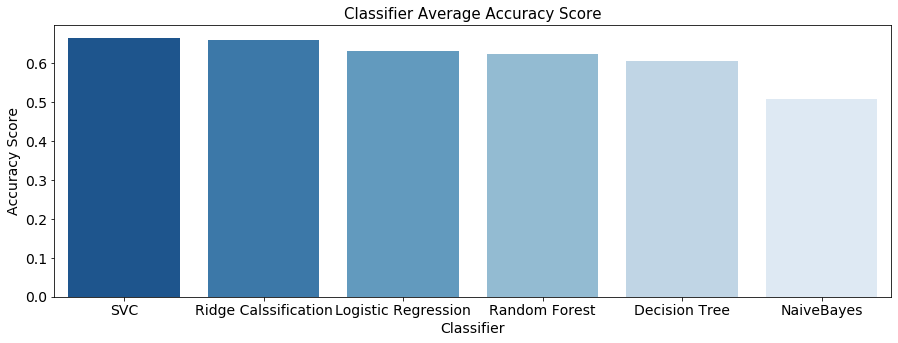

In [60]:
plt.figure(figsize = (15,5))
df_modav = df_modav.sort_values(by="Acc",ascending=False)
sns.barplot(df_modav.index, df_modav.Acc,palette = sns.color_palette("Blues_r"))
plt.ylabel('Accuracy Score', fontsize = 14)
plt.xlabel('Classifier', fontsize = 14)
plt.title('Classifier Average Accuracy Score', fontsize = 15)
plt.tick_params(labelsize = 14)

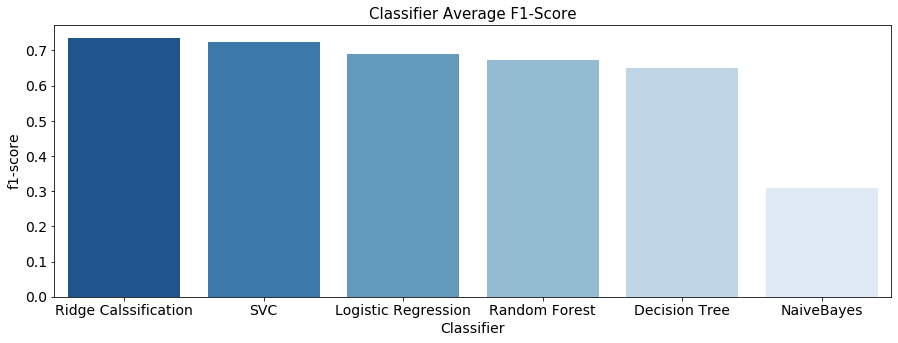

In [61]:
plt.figure(figsize = (15,5))
df_modav = df_modav.sort_values(by="f1-score",ascending=False)
sns.barplot(df_modav.index, df_modav["f1-score"],palette = sns.color_palette("Blues_r"))
plt.ylabel('f1-score', fontsize = 14)
plt.xlabel('Classifier', fontsize = 14)
plt.title('Classifier Average F1-Score', fontsize = 15)
plt.tick_params(labelsize = 14)

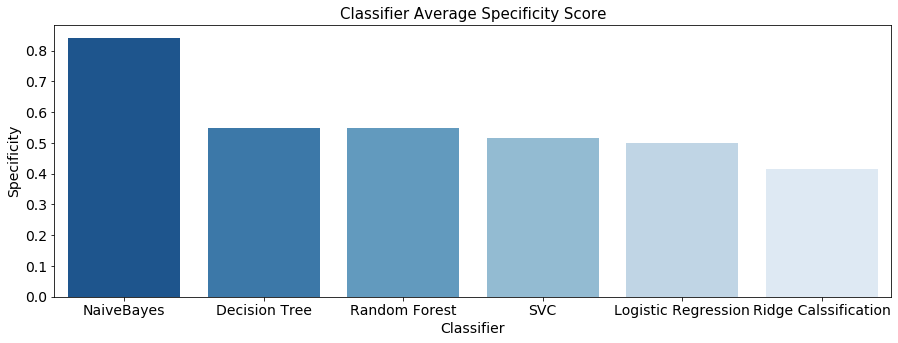

In [62]:
plt.figure(figsize = (15,5))
df_modav = df_modav.sort_values(by="Specificity",ascending=False)
sns.barplot(df_modav.index, df_modav.Specificity,palette = sns.color_palette("Blues_r"))
plt.ylabel('Specificity', fontsize = 14)
plt.xlabel('Classifier', fontsize = 14)
plt.title('Classifier Average Specificity Score', fontsize = 15)
plt.tick_params(labelsize = 14)

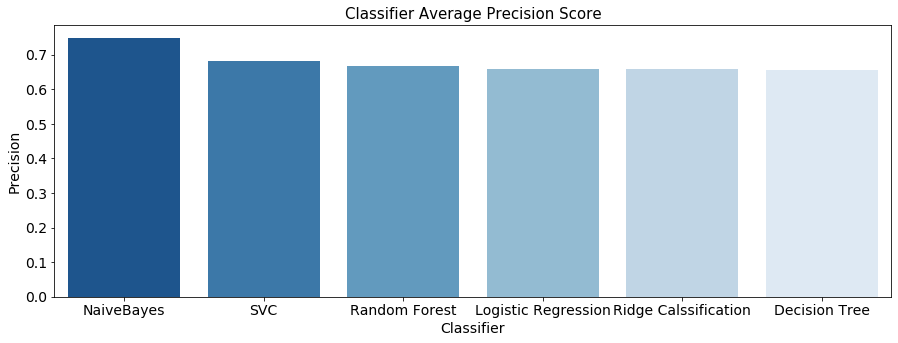

In [63]:
plt.figure(figsize = (15,5))
df_modav = df_modav.sort_values(by="Precision",ascending=False)
sns.barplot(df_modav.index, df_modav.Precision,palette = sns.color_palette("Blues_r"))
plt.ylabel('Precision', fontsize = 14)
plt.xlabel('Classifier', fontsize = 14)
plt.title('Classifier Average Precision Score', fontsize = 15)
plt.tick_params(labelsize = 14)

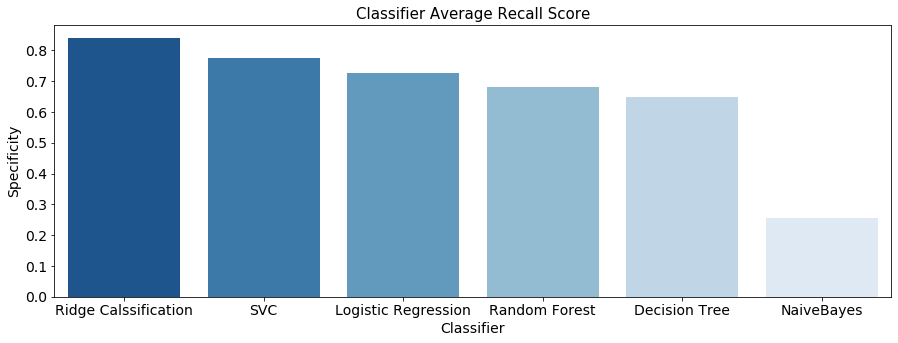

In [64]:
plt.figure(figsize = (15,5))
df_modav = df_modav.sort_values(by="Recall",ascending=False)
sns.barplot(df_modav.index, df_modav.Recall,palette = sns.color_palette("Blues_r"))
plt.ylabel('Specificity', fontsize = 14)
plt.xlabel('Classifier', fontsize = 14)
plt.title('Classifier Average Recall Score', fontsize = 15)
plt.tick_params(labelsize = 14)

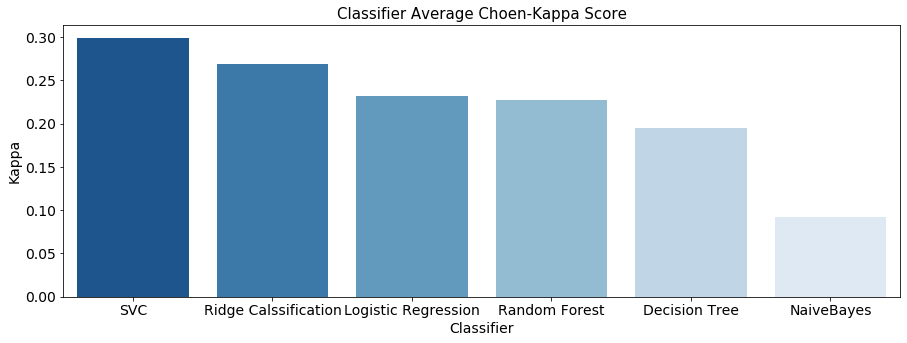

In [65]:
plt.figure(figsize = (15,5))
df_modav = df_modav.sort_values(by="Kappa",ascending=False)
sns.barplot(df_modav.index, df_modav.Kappa,palette = sns.color_palette("Blues_r"))
plt.ylabel('Kappa', fontsize = 14)
plt.xlabel('Classifier', fontsize = 14)
plt.title('Classifier Average Choen-Kappa Score', fontsize = 15)
plt.tick_params(labelsize = 14)

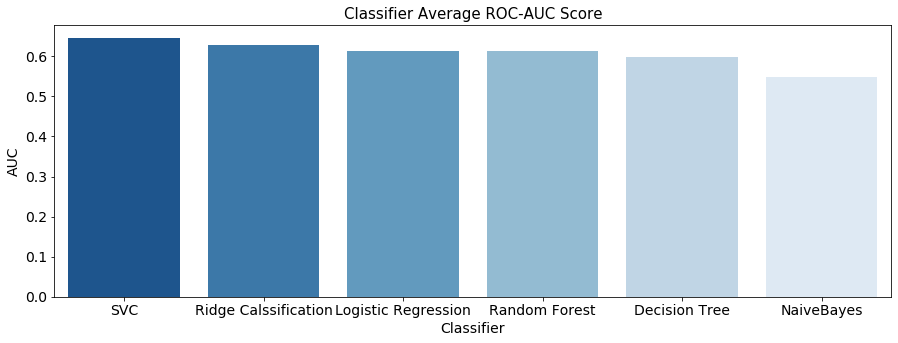

In [66]:
plt.figure(figsize = (15,5))
df_modav = df_modav.sort_values(by="AUC",ascending=False)
sns.barplot(df_modav.index, df_modav.AUC,palette = sns.color_palette("Blues_r"))
plt.ylabel('AUC', fontsize = 14)
plt.xlabel('Classifier', fontsize = 14)
plt.title('Classifier Average ROC-AUC Score', fontsize = 15)
plt.tick_params(labelsize = 14)

In [67]:
# SVC by random forest is still the best model
# overall the RidgeCalssifier dominates the f1-score results
# RidgeClassifier and SVC are mixed for top Accuracy rates
# However the data with highest acc and f1-score are not the best as they dont generalize

In [68]:
top_mod = df_modcomp.iloc[28].values
top_mod = top_mod[:7]
tmkeys = df_modcomp.keys()
tmkeys = tmkeys[:7]
tm = pd.DataFrame(index=tmkeys)
tm["Score"] = top_mod

## Top Classifier - SVC

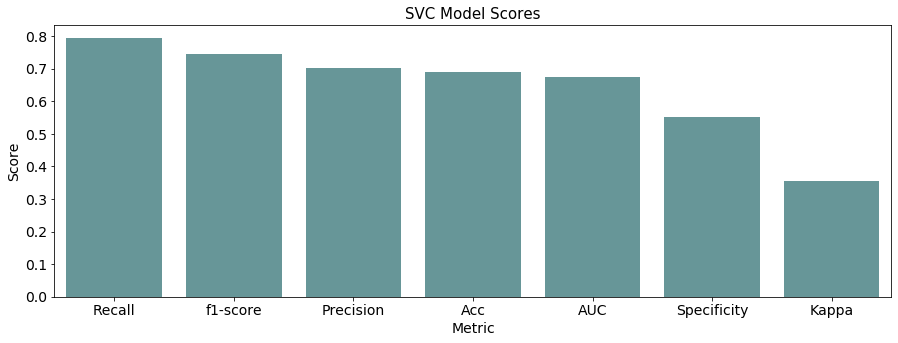

In [69]:
plt.figure(figsize = (15,5))
tm = tm.sort_values(by="Score",ascending=False)
sns.barplot(tm.index,tm.Score,color="cadetblue")
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Metric', fontsize = 14)
plt.title('SVC Model Scores', fontsize = 15)
plt.tick_params(labelsize = 14)

## Classification Results by Course

In [70]:
predictions[4][4].sum()

1226.0

In [71]:
test1 = test.copy()

In [72]:
SVCpreds = predictions[4][4]

In [73]:
## Inspect the results of the SVC on each course

Test Pass Mean: 0.57
Prediction Pass Mean: 0.65


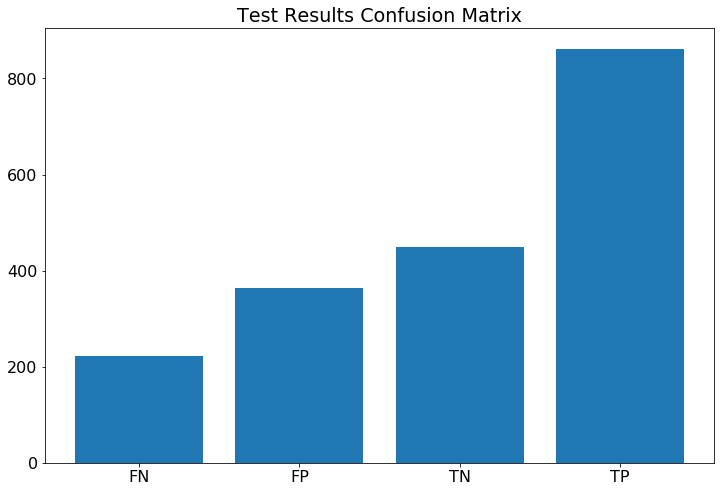

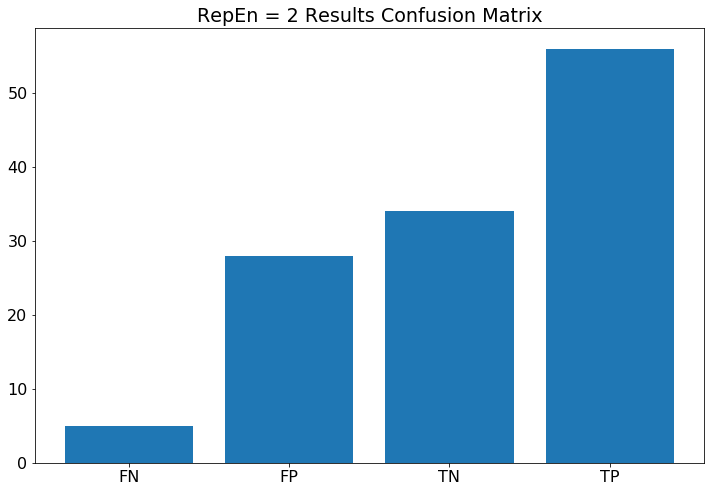

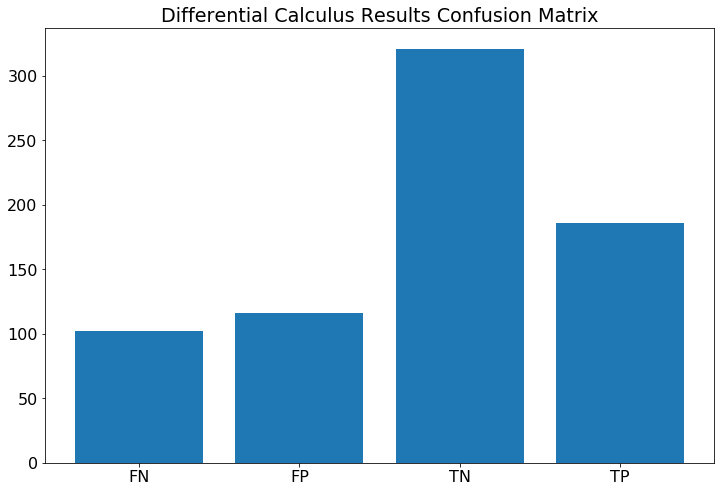

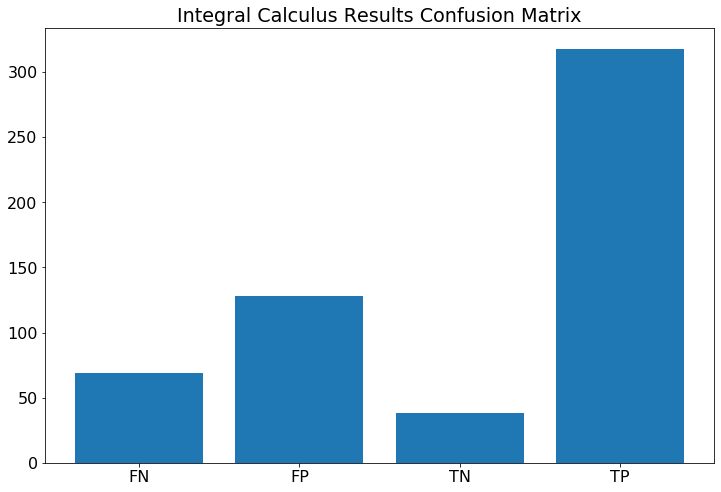

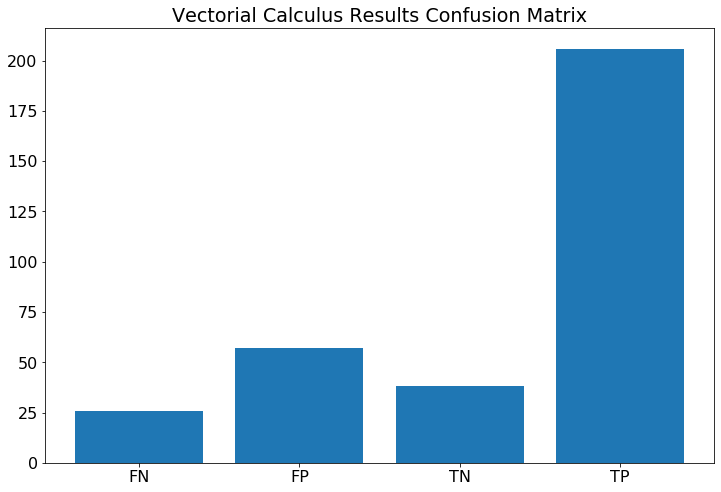

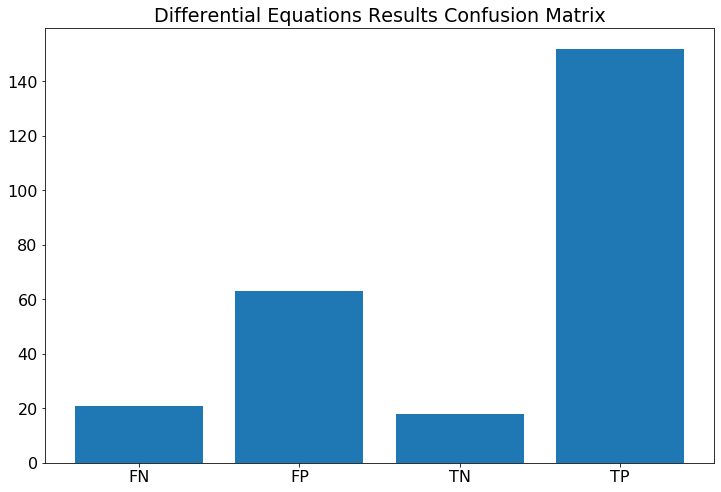

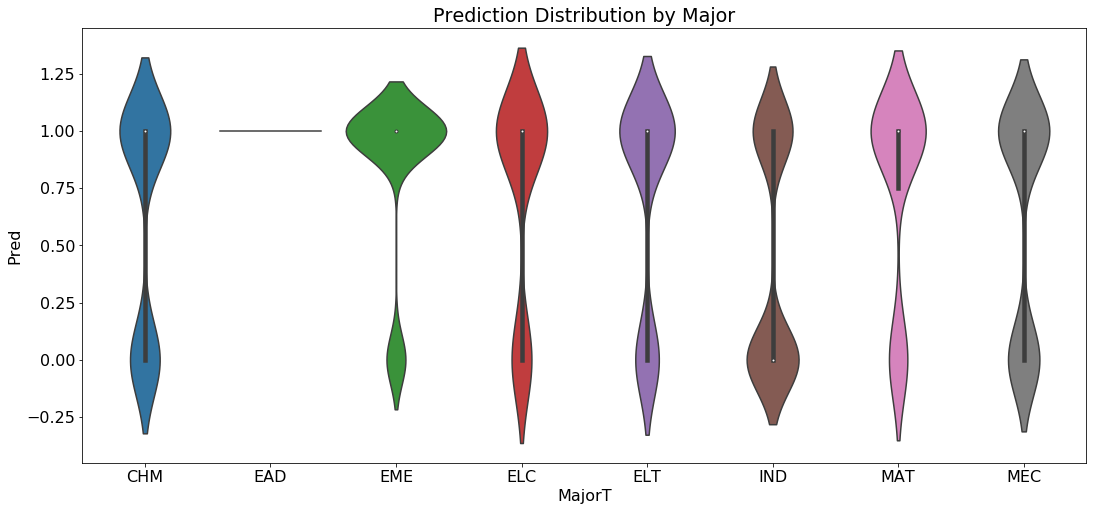

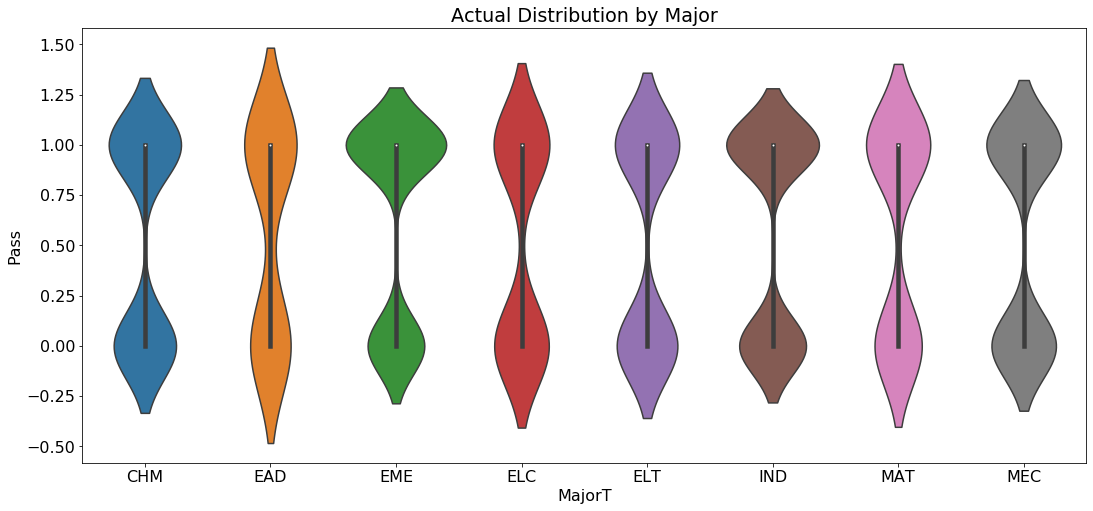

In [74]:
nsem, df_preds = model_eval(test1,SVCpreds)

In [75]:
# Overall the model predicted false positives 

In [76]:
# This dataframe holds the classification results and will be used later after the forecasting
nsem

,CrsEn,Enrolled1,PassOut,PassIn,Fails,ValPass,ValFail,TruePass,TrueFail,FalsePass,FalseFail
0,DifCal,763,302,0,423,293,470,186,354,116,69
1,IntCal,553,446,302,107,387,166,318,38,128,69
2,VecCal,328,263,446,64,232,96,206,39,57,25
3,DifEqs,254,215,263,39,173,81,152,18,63,21


## Organize Historical Data

In [77]:
# Time frame to forecast using OLS and Holt-Winters
# 20131 is the first period which all five classes have data for
p = np.array([20131,20133,20141,20143, 20151, 20153, 20161, 20163,
       20171, 20173, 20181, 20183, 20191, 20193])

In [78]:
# Create a dataframe for all passes and calculate drop out, re-admission, and retention
passt = pstat(p,df_master)
# Dataframe for all fails
fail_ds = fstat(p,df_master)
# Add leftvoer error from re-admission and retention which is summer fails
passt["Error"] = passt.FirstTime  - (passt.Retention + passt.Readmittance - passt.SummerFails)

In [79]:
# Subset Passing Data by course
icp = passt[passt["CrsEn"] == "IntCal"]
vcp = passt[passt["CrsEn"] == "VecCal"]
dep = passt[passt["CrsEn"] == "DifEqs"]

In [80]:
# Subset Fail data by bourse
dcf = fail_ds[fail_ds["CrsEn"] == "DifCal"]
icf = fail_ds[fail_ds["CrsEn"] == "IntCal"]
vcf = fail_ds[fail_ds["CrsEn"] == "VecCal"]
deqf = fail_ds[fail_ds["CrsEn"] == "DifEqs"]
icf

,index,CrsEn,S1,S1_Enrolled,S1_Pass,S1_Fail_Rel,KickOut,S2,S2_Enrolled,Repeat,Retention,Readmittance,Dropout,FirstTime
1,1,IntCal,20131,4,3,1,0,20133,31,2,1,1,0,29
5,1,IntCal,20133,31,8,23,0,20141,58,13,13,0,10,45
9,1,IntCal,20141,58,30,28,0,20143,117,27,18,9,10,90
13,1,IntCal,20143,117,55,62,0,20151,273,47,44,3,18,226
17,1,IntCal,20151,273,187,86,0,20153,221,78,64,14,22,143
21,1,IntCal,20153,221,148,73,0,20161,347,69,67,2,6,278
25,1,IntCal,20161,347,272,75,0,20163,256,61,56,5,19,195
29,1,IntCal,20163,256,161,95,0,20171,431,88,81,7,14,343
33,1,IntCal,20171,431,322,109,0,20173,333,102,87,15,22,231
37,1,IntCal,20173,333,218,115,0,20181,481,113,113,0,2,368


In [81]:
#Combine Data to generate a lagged verision of pass data
ic,vc,de = dfcrspf([icp,vcp,dep],[icf,vcf,deqf])

In [82]:
passag = passt.groupby(by="S1").sum()
passag

,index,S1_LowerOrder,S1_PassInto,S2,S2_Enrolled,FirstTime,Retention,Readmittance,Dropout,SummerFails,Error
S1,,,,,,,,,,,
20131,6,47,29,60399,33,31,27,4,2,0,0
20133,6,116,58,60423,68,55,53,2,5,0,0
20141,6,186,121,60429,162,130,108,23,13,1,0
20143,6,476,312,60453,349,287,275,12,37,0,0
20151,6,554,354,60459,481,376,292,86,62,2,0
20153,6,882,613,60483,679,536,499,37,114,0,0
20161,6,854,636,60489,687,547,466,87,170,6,0
20163,6,1035,726,60513,914,696,615,83,111,2,0
20171,6,1053,752,60519,842,669,561,112,191,4,0


## Show How Following Semester Enrollment Is Calcualted

In [83]:
#Combine Data to generate a lagged verision of failed data
failag = fail_ds.groupby(by="S1").sum()

In [84]:
# Calcualte how many new students enrolled each semester
# They only appear in DifCal
new_studs = fail_ds[fail_ds["CrsEn"] == "DifCal"]
new_studs = new_studs.groupby(by="S1").sum()

In [85]:
summarry = pd.DataFrame(index = p[2:-1])
summarry["Period"] = new_studs.S2[1:-1].values
summarry["Enrolled1"] = failag.S1_Enrolled
summarry["PassRaw"] = failag.S1_Pass
summarry["Pass"] = passag.S1_PassInto
summarry["Fails"] = failag.S1_Fail_Rel
summarry["Estimate"] = summarry.Pass + summarry.Fails
summarry["Enrolled2"] = failag.S2_Enrolled
summarry["NewStu2"] = new_studs.FirstTime
summarry["Error"] = summarry.Enrolled2 - summarry.Estimate
summarry["ErrorStud"] = summarry.Error - summarry.NewStu2

sums = summarry.copy()
sums
# without adding the new students of the followng semester then the estiamtes underestiamte
# By adding the new students then there is over estimation
# Simply adding the passes and fails will not foster an accurate prediction
# Even if the number of incoming students is known


,Period,Enrolled1,PassRaw,Pass,Fails,Estimate,Enrolled2,NewStu2,Error,ErrorStud
20141,20141,187,121,121,66,187,479,290,292,2
20143,20143,479,314,312,165,477,568,138,91,-47
20151,20151,568,365,354,203,557,917,350,360,10
20153,20153,917,629,613,288,901,968,146,67,-79
20161,20161,968,710,636,258,894,1135,373,241,-132
20163,20163,1135,784,726,351,1077,1255,212,178,-34
20171,20171,1255,912,752,343,1095,1405,461,310,-151
20173,20173,1405,966,868,439,1307,1513,284,206,-78
20181,20181,1513,975,787,538,1325,1663,508,338,-170
20183,20183,1663,1086,987,577,1564,1898,482,334,-148


In [86]:
print("Estimate_Error", abs(np.sum(sums.Error)))
print("EstimateStud_Error", abs(np.sum(sums.ErrorStud)))

Estimate_Error 2668
EstimateStud_Error 1193


In [87]:
# Add new students to equation
summarry = pd.DataFrame(index = p[2:-1])
summarry["Period"] = new_studs.S2[1:-1].values
summarry["Enrolled1"] = failag.S1_Enrolled
summarry["PassRaw"] = failag.S1_Pass
summarry["Pass"] = passag.S1_PassInto
summarry["Fails"] = failag.S1_Fail_Rel
summarry["Estimate"] = summarry.Pass + summarry.Fails
summarry["Enrolled2"] = failag.S2_Enrolled
summarry["NewStu2"] = new_studs.FirstTime
summarry["FailRetention"] = failag.Retention
summarry["PassRetention"] = passag.Retention
summarry["RetentionEst"] = failag.Retention + passag.Retention + new_studs.FirstTime
summarry["Error"] = summarry.Enrolled2 - summarry.Estimate
summarry["ErrorStud"] = summarry.Error - summarry.NewStu2
summarry["ErrorRet"] = summarry.Enrolled2 - summarry.RetentionEst

sumret = summarry.copy()
print("Estimate_Error", abs(np.sum(sums.Error)))
print("EstimateStud_Error", abs(np.sum(sums.ErrorStud)))
print("EstRet_Error", abs(np.sum(sumret.ErrorRet)))
sumret

Estimate_Error 2668
EstimateStud_Error 1193
EstRet_Error 1090


,Period,Enrolled1,PassRaw,Pass,Fails,Estimate,Enrolled2,NewStu2,FailRetention,PassRetention,RetentionEst,Error,ErrorStud,ErrorRet
20141,20141,187,121,121,66,187,479,290,45,108,443,292,2,36
20143,20143,479,314,312,165,477,568,138,138,275,551,91,-47,17
20151,20151,568,365,354,203,557,917,350,169,292,811,360,10,106
20153,20153,917,629,613,288,901,968,146,275,499,920,67,-79,48
20161,20161,968,710,636,258,894,1135,373,197,466,1036,241,-132,99
20163,20163,1135,784,726,351,1077,1255,212,325,615,1152,178,-34,103
20171,20171,1255,912,752,343,1095,1405,461,255,561,1277,310,-151,128
20173,20173,1405,966,868,439,1307,1513,284,429,732,1445,206,-78,68
20181,20181,1513,975,787,538,1325,1663,508,401,569,1478,338,-170,185
20183,20183,1663,1086,987,577,1564,1898,482,540,778,1800,334,-148,98


In [88]:
# Add Re-addmission students
summarry = pd.DataFrame(index = p[2:-1])
summarry["Period"] = new_studs.S2[1:-1].values
summarry["Enrolled1"] = failag.S1_Enrolled
summarry["PassRaw"] = failag.S1_Pass
summarry["Pass"] = passag.S1_PassInto
summarry["Fails"] = failag.S1_Fail_Rel
summarry["Estimate"] = summarry.Pass + summarry.Fails
summarry["Enrolled2"] = failag.S2_Enrolled
summarry["NewStu2"] = new_studs.FirstTime
summarry["FailRetention"] = failag.Retention
summarry["PassRetention"] = passag.Retention
summarry["PassReAd"] = passag.Readmittance
summarry["FailReAd"] = failag.Readmittance
summarry["RetentionEst"] = summarry.FailRetention + summarry.PassRetention + summarry.NewStu2
summarry["RR_Est"] = summarry.RetentionEst + summarry.PassReAd + summarry.FailReAd
summarry["Error"] = summarry.Enrolled2 - summarry.Estimate
summarry["ErrorStud"] = summarry.Error - summarry.NewStu2
summarry["ErrorRet"] = summarry.Enrolled2 - summarry.RetentionEst
summarry["RR_Error"] = summarry.Enrolled2 - summarry.RR_Est

sumRR = summarry.copy()
print("Estimate_Error", abs(np.sum(sums.Error)))
print("EstimateStud_Error", abs(np.sum(sums.ErrorStud)))
print("EstRet_Error", abs(np.sum(sumret.ErrorRet)))
print("EstRR_Error", abs(np.sum(sumRR.RR_Error)))
sumRR


Estimate_Error 2668
EstimateStud_Error 1193
EstRet_Error 1090
EstRR_Error 27


,Period,Enrolled1,PassRaw,Pass,Fails,Estimate,Enrolled2,NewStu2,FailRetention,PassRetention,PassReAd,FailReAd,RetentionEst,RR_Est,Error,ErrorStud,ErrorRet,RR_Error
20141,20141,187,121,121,66,187,479,290,45,108,23,14,443,480,292,2,36,-1
20143,20143,479,314,312,165,477,568,138,138,275,12,5,551,568,91,-47,17,0
20151,20151,568,365,354,203,557,917,350,169,292,86,22,811,919,360,10,106,-2
20153,20153,917,629,613,288,901,968,146,275,499,37,11,920,968,67,-79,48,0
20161,20161,968,710,636,258,894,1135,373,197,466,87,18,1036,1141,241,-132,99,-6
20163,20163,1135,784,726,351,1077,1255,212,325,615,83,22,1152,1257,178,-34,103,-2
20171,20171,1255,912,752,343,1095,1405,461,255,561,112,20,1277,1409,310,-151,128,-4
20173,20173,1405,966,868,439,1307,1513,284,429,732,60,8,1445,1513,206,-78,68,0
20181,20181,1513,975,787,538,1325,1663,508,401,569,175,20,1478,1673,338,-170,185,-10
20183,20183,1663,1086,987,577,1564,1898,482,540,778,74,24,1800,1898,334,-148,98,0


In [89]:
# The last component of error is students that failed in teh summer between semesters
summarry = pd.DataFrame(index = p[2:-1])
summarry["Period2"] = new_studs.S2[2:].values
summarry["Enrolled1"] = failag.S1_Enrolled
summarry["PassRaw"] = failag.S1_Pass
summarry["Pass"] = passag.S1_PassInto
summarry["Fails"] = failag.S1_Fail_Rel
summarry["Estimate"] = summarry.Pass + summarry.Fails
summarry["Enrolled2"] = failag.S2_Enrolled
summarry["NewStu2"] = new_studs.FirstTime
summarry["FailRetention"] = failag.Retention
summarry["PassRetention"] = passag.Retention
summarry["PassReAd"] = passag.Readmittance
summarry["FailReAd"] = failag.Readmittance
summarry["RetentionEst"] = summarry.FailRetention + summarry.PassRetention + summarry.NewStu2
summarry["RR_Est"] = summarry.RetentionEst + summarry.PassReAd + summarry.FailReAd
summarry["Error"] = summarry.Enrolled2 - summarry.Estimate
summarry["ErrorStud"] = summarry.Error - summarry.NewStu2
summarry["ErrorRet"] = summarry.Enrolled2 - summarry.RetentionEst
summarry["RR_Error"] = summarry.Enrolled2 - summarry.RR_Est
summarry["SF_Error"] = summarry.Enrolled2 - summarry.RR_Est + passag.SummerFails
sumSF = summarry.copy()
print("Estimate_Error", abs(np.sum(sums.Error)))
print("EstimateStud_Error", abs(np.sum(sums.ErrorStud)))
print("EstRet_Error", abs(np.sum(sumret.ErrorRet)))
print("EstRR_Error", abs(np.sum(sumRR.RR_Error)))
print("SF_Error", abs(np.sum(sumSF.SF_Error)))
sumSF

Estimate_Error 2668
EstimateStud_Error 1193
EstRet_Error 1090
EstRR_Error 27
SF_Error 0.0


,Period2,Enrolled1,PassRaw,Pass,Fails,Estimate,Enrolled2,NewStu2,FailRetention,PassRetention,PassReAd,FailReAd,RetentionEst,RR_Est,Error,ErrorStud,ErrorRet,RR_Error,SF_Error
20141,20143,187,121,121,66,187,479,290,45,108,23,14,443,480,292,2,36,-1,0.0
20143,20151,479,314,312,165,477,568,138,138,275,12,5,551,568,91,-47,17,0,0.0
20151,20153,568,365,354,203,557,917,350,169,292,86,22,811,919,360,10,106,-2,0.0
20153,20161,917,629,613,288,901,968,146,275,499,37,11,920,968,67,-79,48,0,0.0
20161,20163,968,710,636,258,894,1135,373,197,466,87,18,1036,1141,241,-132,99,-6,0.0
20163,20171,1135,784,726,351,1077,1255,212,325,615,83,22,1152,1257,178,-34,103,-2,0.0
20171,20173,1255,912,752,343,1095,1405,461,255,561,112,20,1277,1409,310,-151,128,-4,0.0
20173,20181,1405,966,868,439,1307,1513,284,429,732,60,8,1445,1513,206,-78,68,0,0.0
20181,20183,1513,975,787,538,1325,1663,508,401,569,175,20,1478,1673,338,-170,185,-10,0.0
20183,20191,1663,1086,987,577,1564,1898,482,540,778,74,24,1800,1898,334,-148,98,0,0.0


In [90]:
regd = sumSF

## Holt-Winters Forecast for New Students &  Re-admissions

In [91]:
# Forecast New Students
data = regd.NewStu2
train = data[:9].values
test = data[9:].values

In [92]:
hw(train,test,2)

Residual SSE:
1 2021.5385780565452
2 6794.727053344946
3 2044.314201788242
4 6113.788356388645


In [93]:
regd.NewStu2

20141    290
20143    138
20151    350
20153    146
20161    373
20163    212
20171    461
20173    284
20181    508
20183    482
20191    617
Name: NewStu2, dtype: int64

In [94]:
# Store data in a dataframe to access later
componentEST = pd.DataFrame(index = p[2:-1])

In [95]:
studf = hwp(train,test,2,"add","add")

In [96]:
componentEST["NewStuds"] = studf

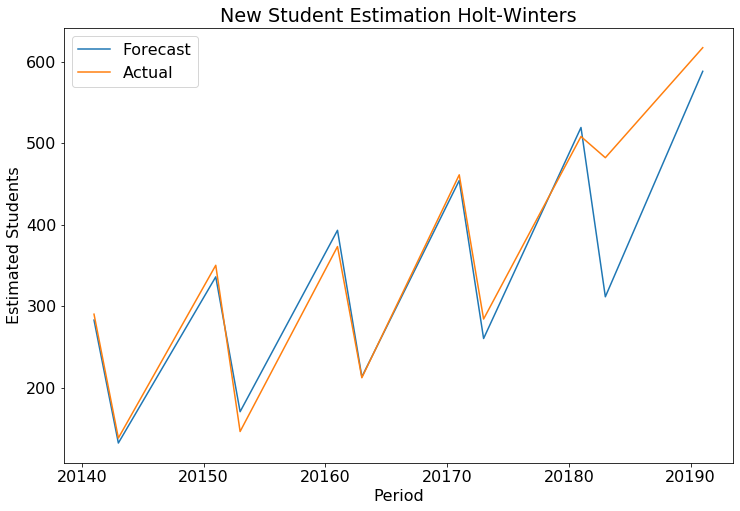

In [97]:
plt.plot(regd.index,studf,label = "Forecast")
plt.plot(regd.index,regd.NewStu2,label = "Actual")
plt.title("New Student Estimation Holt-Winters")
plt.ylabel("Estimated Students")
plt.xlabel("Period")
plt.legend(loc = "best");

In [98]:
# Exploring retention rates
trainFR = regd.FailRetention[:9].values
testFR = regd.FailRetention[9:].values
hw(trainFR,testFR,2)

Residual SSE:
1 11000.747237585005
2 10110.328295192565
3 6482.029741562737
4 36646.684030892015


In [99]:
FRf = hwp(trainFR,testFR,2,"mul","add")

In [100]:
componentEST["FailRet"] = FRf

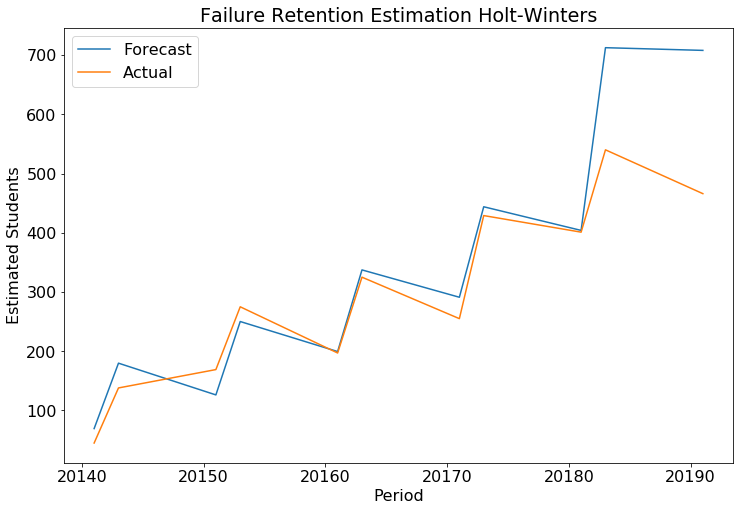

In [101]:
plt.plot(regd.index,FRf,label = "Forecast")
plt.plot(regd.index,regd.FailRetention, label = "Actual")
plt.title("Failure Retention Estimation Holt-Winters")
plt.ylabel("Estimated Students")
plt.xlabel("Period")
plt.legend(loc = "best");

In [102]:
# Forecast Re-admissions
trainFA = regd.FailReAd[:9].values
testFA = regd.FailReAd[9:].values
hw(trainFA,testFA,3)

Residual SSE:
1 175.46036122548753
2 246.53214881057224
3 191.25515771921852
4 246.53214881057224


In [103]:
hw(trainFA,testFA,3)
FAf = hwp(trainFA,testFA,3,"add","add")

Residual SSE:
1 175.46036122548753
2 246.53214881057224
3 191.25515771921852
4 246.53214881057224


In [104]:
componentEST["FailReAd"] = FAf

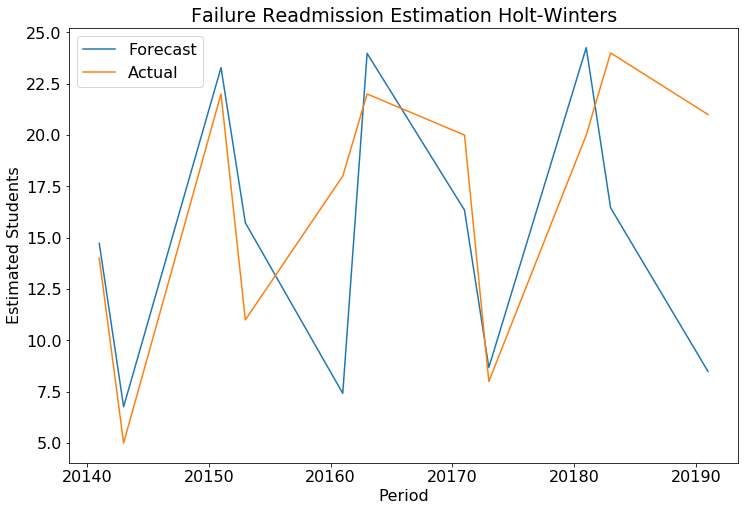

In [105]:
plt.plot(regd.index,FAf,label = "Forecast")
plt.plot(regd.index,regd.FailReAd, label = "Actual")
plt.title("Failure Readmission Estimation Holt-Winters")
plt.ylabel("Estimated Students")
plt.xlabel("Period")
plt.legend(loc = "best");

In [106]:
trainPRA= regd.PassReAd[:9].values
testPRA = regd.PassReAd[9:].values
hw(trainPRA,testPRA,2)

Residual SSE:
1 2420.773351433031
2 2927.950358628052
3 86676.36082208954
4 2844.8525355209385


In [107]:
praf = hwp(trainPRA,testPRA,2,"add","add")

In [108]:
componentEST["PassRead"] = praf

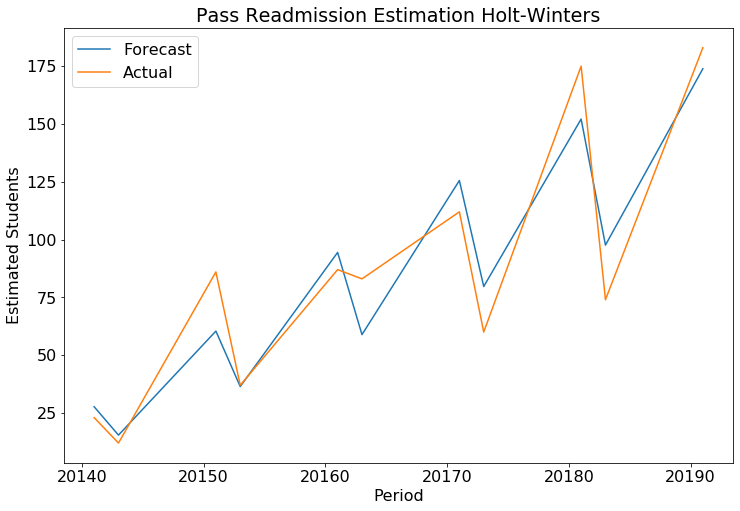

In [109]:
plt.plot(regd.index,praf,label = "Forecast")
plt.plot(regd.index,regd.PassReAd, label = "Actual")
plt.title("Pass Readmission Estimation Holt-Winters")
plt.ylabel("Estimated Students")
plt.xlabel("Period")
plt.legend(loc = "best");

In [110]:
trainPR= regd.PassRetention[:9].values
testPR = regd.PassRetention[9:].values
hw(trainPR,testPR,2)

Residual SSE:
1 14238.7524900682
2 31410.467843137354
3 67235.63162468682
4 nan


In [111]:
prf = hwp(trainPR,testPR,2,"add","add")

In [112]:
componentEST["PassRetention"] = prf

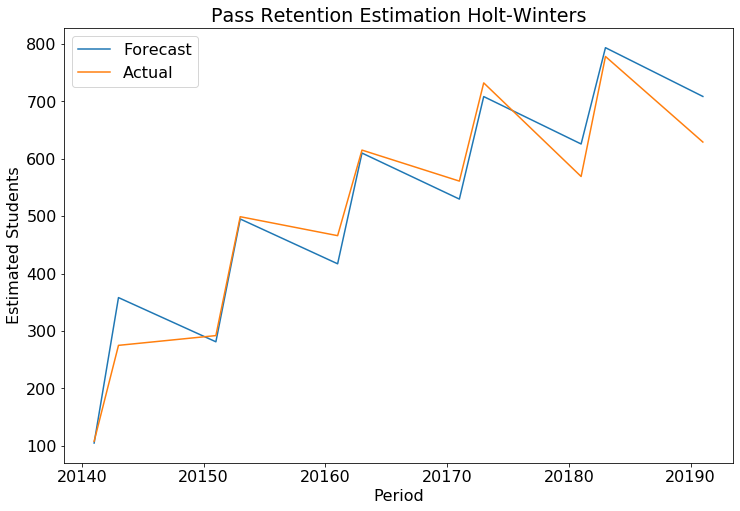

In [113]:
plt.plot(regd.index,prf,label = "Forecast")
plt.plot(regd.index,regd.PassRetention, label = "Actual")
plt.title("Pass Retention Estimation Holt-Winters")
plt.ylabel("Estimated Students")
plt.xlabel("Period")
plt.legend(loc = "best");

In [114]:
padaug = passag.SummerFails + 1

In [115]:
trainSF= padaug[2:11].values
testSF = padaug[11:].values
hw(trainSF,testSF,2)

Residual SSE:
1 46.052865234669184
2 nan
3 55.100524465192564
4 nan


In [116]:
smf = hwp(trainSF,testSF,2,"add","add")

In [117]:
smf1 = smf -1
smf1 = smf1.round()

In [118]:
componentEST["SummerFails"] = smf1

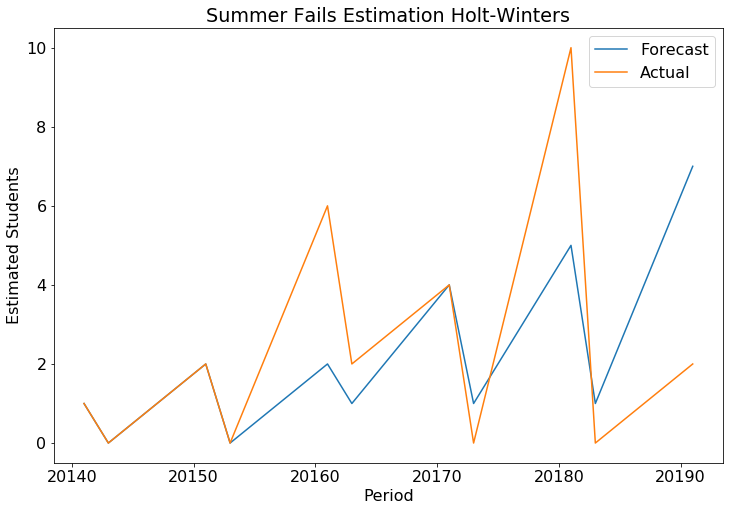

In [119]:
plt.plot(regd.index,smf1,label = "Forecast")
plt.plot(regd.index,passag.SummerFails[2:], label = "Actual")
plt.title("Summer Fails Estimation Holt-Winters")
plt.ylabel("Estimated Students")
plt.xlabel("Period")
plt.legend(loc = "best");

In [120]:
cme = round(componentEST)

In [121]:
cme["Prediction"] = cme.NewStuds + cme.FailReAd + cme.FailRet + cme.PassRetention + cme.PassRead + cme.SummerFails

In [122]:
cme["Actual"] = regd["Enrolled2"]

In [123]:
cme["Error"] = cme.Actual - cme.Prediction

In [124]:
cme.index = regd.Period2

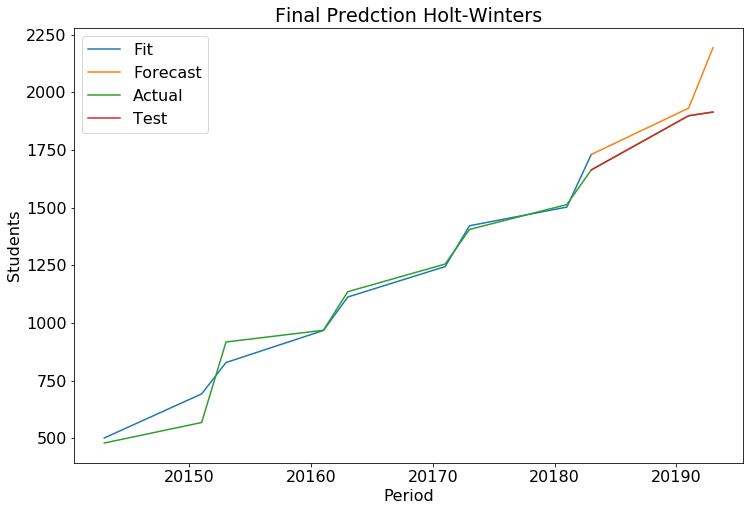

In [125]:
plt.plot(cme.index[:9],cme.Prediction[:9], label = "Fit")
plt.plot(cme.index[8:],cme.Prediction[8:], label = "Forecast")
plt.plot(cme.index,cme.Actual, label = "Actual")
plt.plot(cme.index[8:],cme.Actual[8:], label = "Test")
plt.title("Final Predction Holt-Winters")
plt.ylabel("Students")
plt.xlabel("Period")
plt.legend(loc = "best");

In [126]:
# most of the error comes from predicted failure and pas retentions
# The model under estimates the actaul values
# These estiamtions are off by hundreds
# The early periods exhibit uncertainty as there are darstic increaeses each semester
# The fit does well in the middle as increases are still tredning and in smaller jumps
# The predictions are quite are not too bade except for the last point
# This is due to most likely that the univesity was reaching its max capacity and is leveling off
# However the model does not know this and predicted an increase

## Retention Prediction w/ OLS & Re-admission with HW by Course

In [127]:
dcfrn = dcf[["S1_Enrolled","S1_Pass","S1_Fail_Rel","S2",
               "S2_Enrolled","Retention","Readmittance"]]
dcfOLS = dcfrn.rename(columns={"S1_Enrolled":"Enrolled1","S1_Pass":"PassOut",
                              "S1_Fail_Rel":"Fail","S2_Enrolled":"Enrolled2",
                              "Retention":"Fret","Readmittance":"Frad"})
dcfOLS.index = ic.index    

In [128]:
def crsHW(df,target,period,trend,seas):
    if df[target].min() == 0:
        rad = df[target] + 1
        trainFA = rad[:11].values
        testFA = rad[11:].values
        hw(trainFA,testFA,period)
        dcfa = hwp(trainFA,testFA,period,trend,seas)
        dcfa = (dcfa - 1).round()
        return dcfa
    else:
        rad = df[target]
        train = rad[:11].values
        test = rad[11:].values
        hw(train,test,period)
        dcfa = hwp(train,test,period,trend,seas)
        return dcfa
        

In [129]:
DC_frad = crsHW(dcfOLS,"Frad",2,"add","add")

Residual SSE:
1 38.908830662347015
2 nan
3 105.64446579566557
4 nan


In [130]:
def crsDifCal(df):
    dcfOLS = df
    dctrain = dcfOLS[:11]
    dctest  = dcfOLS[11:]
    dcXtrain = dctrain[["Enrolled1","Fail"]]
    dcYtrain = dctrain[["Fret"]]
    dcXtest = dctest[["Enrolled1","Fail"]]
    dcYtest = dctest[["Fret"]]
    
    #Adding constant column of ones, mandatory for sm.OLS model
    X_1 = sm.add_constant(dcXtrain)
    #Fitting sm.OLS model
    model = sm.OLS(dcYtrain.Fret,X_1).fit()
    model.pvalues
    print(model.summary())
    Xtest = sm.add_constant(dcXtest)
    yhat = model.predict(Xtest)
    print(yhat)
    print(dcYtest.Fret)
    dcfret = model.params
    
    return dcfret

In [131]:
dcfret_mprams = crsDifCal(dcfOLS)
dcfret_mprams

                            OLS Regression Results                            
Dep. Variable:                   Fret   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     246.4
Date:                Thu, 07 May 2020   Prob (F-statistic):           6.51e-08
Time:                        14:36:39   Log-Likelihood:                -38.259
No. Observations:                  11   AIC:                             82.52
Df Residuals:                       8   BIC:                             83.71
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.3814      5.846     -1.605      0.1

const       -9.381373
Enrolled1    0.134566
Fail         0.597288
dtype: float64

In [132]:
def crsIntCal(df):
    train = df[:11]
    test  = df[11:]
    Xtrain = train[["Fail"]]
    Ytrain = train[["Fret","Pret"]]
    Xtest = test[["Fail"]]
    Ytest = test[["Fret","Pret"]]
    
    # predicting Failure Retention
    #Adding constant column of ones, mandatory for sm.OLS model
    X_1 = sm.add_constant(Xtrain)
    #Fitting sm.OLS model
    model1 = sm.OLS(Ytrain.Fret,X_1).fit()
    fret = model1.params
    model1.pvalues
    print(model1.summary())
    Xtest = sm.add_constant(Xtest)
    yhat = model1.predict(Xtest)
    print(yhat)
    print(Ytest.Fret)
    
    Xtrain = train[["PassIn"]]
    Xtest = test[["PassIn"]]
    X_1 = sm.add_constant(Xtrain)
    model2 = sm.OLS(Ytrain.Pret,X_1).fit()
    pret = model2.params
    print(model2.summary())
    Xtest = sm.add_constant(Xtest)
    yhat = model2.predict(Xtest)
    print(yhat)
    print(Ytest.Pret)
    
    normal_eqs = [fret,pret]
    return normal_eqs

In [133]:
icret_mprams = crsIntCal(ic)

                            OLS Regression Results                            
Dep. Variable:                   Fret   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     164.5
Date:                Thu, 07 May 2020   Prob (F-statistic):           4.35e-07
Time:                        14:36:53   Log-Likelihood:                -38.915
No. Observations:                  11   AIC:                             81.83
Df Residuals:                       9   BIC:                             82.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9946      5.560     -0.359      0.7

In [134]:
ic_frad = crsHW(ic,"Frad",2,"add","add")
ic_prad = crsHW(ic,"Prad",2,"add","add")
ic_smf = crsHW(ic,"SummerFails",2,"add","add")

Residual SSE:
1 176.7999964761351
2 nan
3 2384.954513832884
4 nan
Residual SSE:
1 660.5996933341931
2 nan
3 28917.674316488985
4 nan
Residual SSE:
1 23.440780446005107
2 nan
3 25.65824117666427
4 nan


In [135]:
def crsVecCal(df):
    train = df[:11]
    test  = df[11:]
    Xtrain = train[["Fail"]]
    Ytrain = train[["Fret","Pret"]]
    Xtest = test[["Fail"]]
    Ytest = test[["Fret","Pret"]]
    
    # predicting Failure Retention
    #Adding constant column of ones, mandatory for sm.OLS model
    X_1 = sm.add_constant(Xtrain)
    #Fitting sm.OLS model
    model1 = sm.OLS(Ytrain.Fret,X_1).fit()
    fret = model1.params
    model1.pvalues
    print(model1.summary())
    Xtest = sm.add_constant(Xtest)
    yhat = model1.predict(Xtest)
    print(yhat)
    print(Ytest.Fret)
    
    Xtrain = train[["PassIn"]]
    Xtest = test[["PassIn"]]
    X_1 = sm.add_constant(Xtrain)
    model2 = sm.OLS(Ytrain.Pret,X_1).fit()
    pret = model2.params
    print(model2.summary())
    Xtest = sm.add_constant(Xtest)
    yhat = model2.predict(Xtest)
    print(yhat)
    print(Ytest.Pret)
    
    normal_eqs = [fret,pret]
    return normal_eqs

In [136]:
vcret_mprams = crsVecCal(vc)

                            OLS Regression Results                            
Dep. Variable:                   Fret   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     157.6
Date:                Thu, 07 May 2020   Prob (F-statistic):           5.24e-07
Time:                        14:37:17   Log-Likelihood:                -36.433
No. Observations:                  11   AIC:                             76.87
Df Residuals:                       9   BIC:                             77.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6803      3.637     -0.187      0.8

In [137]:
vc_frad = crsHW(vc,"Frad",3,"add","add")
vc_prad = crsHW(vc,"Prad",2,"add","add")
vc_smf = crsHW(vc,"SummerFails",2,"add","add")

Residual SSE:
1 57.552568259541005
2 nan
3 97.6000774549288
4 nan
Residual SSE:
1 2434.0141962866164
2 nan
3 152359.62150136736
4 nan
Residual SSE:
1 1.9640743096007403
2 nan
3 1.9896477654133333
4 nan


In [138]:
def crsDifEqs(df):
    train = df[:11]
    test  = df[11:]
    Xtrain = train[["Fail"]]
    Ytrain = train[["Fret","Pret"]]
    Xtest = test[["Fail"]]
    Ytest = test[["Fret","Pret"]]
    
    # predicting Failure Reten,ion
    #Adding constant column of ones, mandatory for sm.OLS model
    X_1 = sm.add_constant(Xtrain)
    #Fitting sm.OLS model
    model1 = sm.OLS(Ytrain.Fret,X_1).fit()
    fret = model1.params
    model1.pvalues
    print(model1.summary())
    Xtest = sm.add_constant(Xtest)
    yhat = model1.predict(Xtest)
    print(yhat)
    print(Ytest.Fret)
    
    Xtrain = train[["PassIn"]]
    Xtest = test[["PassIn"]]
    X_1 = sm.add_constant(Xtrain)
    model2 = sm.OLS(Ytrain.Pret,X_1).fit()
    pret = model2.params
    print(model2.summary())
    Xtest = sm.add_constant(Xtest)
    yhat = model2.predict(Xtest)
    print(yhat)
    print(Ytest.Pret)
    
    normal_eqs = [fret,pret]
    return normal_eqs

In [139]:
deret_mprams = crsDifEqs(de)

                            OLS Regression Results                            
Dep. Variable:                   Fret   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     79.99
Date:                Thu, 07 May 2020   Prob (F-statistic):           8.99e-06
Time:                        14:38:02   Log-Likelihood:                -33.068
No. Observations:                  11   AIC:                             70.14
Df Residuals:                       9   BIC:                             70.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1893      2.397      0.079      0.9

In [140]:
de_frad = crsHW(de,"Frad",2,"add","add")
de_prad = crsHW(de,"Prad",2,"add","add")
de_smf = crsHW(de,"SummerFails",2,"add","add")

Residual SSE:
1 54.82279693480393
2 nan
3 123.83962354356602
4 nan
Residual SSE:
1 105.1220076423608
2 nan
3 2343.82498308821
4 nan
Residual SSE:
1 32.0416598577741
2 nan
3 64.95303224554326
4 nan


## Combine Holt-Winters Results Into DataFrames by Course

In [141]:
# independently forecasted
DCadjtab = pd.DataFrame(index = cme.index)
DCadjtab["NewStuds"] = cme.NewStuds
DCadjtab["FailAds"] = DC_frad[2:]

In [142]:
ICadjtab = pd.DataFrame(index = cme.index)
ICadjtab["Frad"] = ic_frad[2:]
ICadjtab["Prad"] = ic_prad[2:]
ICadjtab["SMF"] = ic_smf[2:]

In [143]:
VCadjtab = pd.DataFrame(index = cme.index)
VCadjtab["Frad"] = vc_frad[2:]
VCadjtab["Prad"] = vc_prad[2:]
VCadjtab["SMF"] = vc_smf[2:]

In [144]:
DEadjtab = pd.DataFrame(index = cme.index)
DEadjtab["Frad"] = de_frad[2:]
DEadjtab["Prad"] = de_prad[2:]
DEadjtab["SMF"] = de_smf[2:]

In [145]:
adjtabs = [DCadjtab,ICadjtab,VCadjtab,DEadjtab]

## Recall OLS models for each course 

In [146]:
# dc retention equation
b = dcfret_mprams.values
c = icret_mprams[0].values
d = icret_mprams[1].values
e = vcret_mprams[0].values
f = vcret_mprams[1].values
g = deret_mprams[0].values
h = deret_mprams[1].values

In [147]:
# all retention parameters
fret_prams = [b,c,e,g]
pret_prams = [d,f,h]

## Combine All Results (Classification, OLS, Holt-Winters)

In [148]:
def estDC(next_sem,adjtabs,fret_prams,pret_prams,fperiod,fail_ds,passt):
    # Gather Actual Data for predicted semester
    ph = passt[passt["S2"] == fperiod]
    ph.index = ph["index"]
    ph1 = ph.iloc[:,8:12]
    ph1 = ph1.rename(columns={"Retention": "Pret", "Readmittance": "Prad"})
    gh = fail_ds[fail_ds["S2"] == fperiod]
    gh1 = gh.iloc[:,8:]
    gh2 = gh1.reset_index()
    gh3 = gh2.drop(columns="index",axis=1)
    nst = np.zeros(4)
    for i in range(1):
        if i == 0:
            nst[i] = gh3.FirstTime[i]
    gh3["NewStudents"] = nst   
    gh3 = gh3.rename(columns={"Retention": "Fret", "Readmittance": "Frad"})
    fg = pd.concat([gh3,ph1],axis=1)
    fg = fg.fillna(0)
    fg1 = fg[["S2_Enrolled","NewStudents","Fret","Pret","Frad","Prad","SummerFails"]]
    fg1["Admin"] = fg1.Frad + fg1.NewStudents + fg1.Prad + fg1.SummerFails
    

    # Prepare Fail Predictions for retention prediction
    # Also get predictions from actual results for error analysis
    dcfret = [1,next_sem.Enrolled1[0],next_sem.Fails[0]]
    dcv = [1,next_sem.Enrolled1[0],next_sem.ValFail[0]]
    icfret = [1,next_sem.Fails[1]]
    icv = [1,next_sem.ValFail[1]]
    vcfret = [1,next_sem.Fails[1]]
    vcv = [1,next_sem.ValFail[1]]
    defret = [1,next_sem.Fails[3]]
    dev = [1,next_sem.ValFail[3]]
    frets = [dcfret,icfret,vcfret,defret]
    vfrets = [dcv,icv,vcv,dev]
    
    # Prepare Pass Predictions for retention prediction
    # Also get predictions from actual results for error analysis
    
    icpret = [1,next_sem.PassIn[1]]
    icv1 = [1,next_sem.ValPass[1]]
    vcpret = [1,next_sem.PassIn[2]]
    vcv1 = [1,next_sem.ValPass[2]]
    depret = [1,next_sem.PassIn[3]]
    dev1 = [1,next_sem.ValPass[3]]
    prets = [icpret,vcpret,depret]
    vprets = [icv1,vcv1,dev1]
    
    # Feed predictions and actual truth data with OLS models
    fret_pred = []
    pret_pred = [0]
    fret_true = []
    pret_true = [0]
    
    for i in range(4):
        pred = fret_prams[i] @ frets[i]
        fret_pred.append(pred)
        
    for i in range(3):
        pred = pret_prams[i] @ prets[i]
        pret_pred.append(pred)
                
    for i in range(4):
        pred = fret_prams[i] @ vfrets[i]
        fret_true.append(pred)
        
    for i in range(3):
        pred = pret_prams[i] @ vprets[i]
        pret_true.append(pred)
    
    # Add new students and readimtance data to final dataframe
    adjs = []
    for i in adjtabs:
        x = i.loc[fperiod].values
        x1 = np.sum(x)
        adjs.append(x1)
        
    next_sem["PretTrue"] = pret_true
    next_sem["FretTrue"] = fret_true   
    next_sem["PredAdmin"] = adjs
    next_sem["PredFret"] = fret_pred
    next_sem["PredPret"] = pret_pred
    next_sem["Final_Pred"] = next_sem.PredAdmin + next_sem.PredFret + next_sem.PredPret
    
    df_final = round(pd.concat([next_sem,fg1],axis=1))
    
    # Create an Error Datafame to evaluate full model
    df_error = pd.DataFrame(index=[0,1,2,3])
    df_error["CrsEn"] = df_final.CrsEn
    df_error["Total"] = df_final.S2_Enrolled - df_final.Final_Pred
    df_error["Admin"] = df_final.Admin - df_final.PredAdmin
    df_error["Fret"] = df_final.Fret - df_final.PredFret
    df_error["Pret"] = df_final.Pret - df_final.PredPret
    df_error["FalsePass"] = df_final.FalsePass
    df_error["FalseFail"] = df_final.FalseFail
    df_error["PretError"] = df_final.Pret - df_final.PretTrue
    df_error["FretError"] = df_final.Fret - df_final.FretTrue

    return df_final, df_error


In [149]:
# Add classifcation results, OLS model, and HW forceasts to compare agains actual data
final, error = estDC(nsem,adjtabs,fret_prams,pret_prams,20193,fail_ds,passt)

In [150]:
final

,CrsEn,Enrolled1,PassOut,PassIn,Fails,ValPass,ValFail,TruePass,TrueFail,FalsePass,...,PredPret,Final_Pred,S2_Enrolled,NewStudents,Fret,Pret,Frad,Prad,SummerFails,Admin
0,DifCal,763,302,0,423,293,470,186,354,116,...,0.0,935.0,898,617.0,275,0.0,6,0.0,0.0,623.0
1,IntCal,553,446,302,107,387,166,318,38,128,...,283.0,423.0,403,0.0,106,240.0,9,50.0,2.0,61.0
2,VecCal,328,263,446,64,232,96,206,39,57,...,387.0,559.0,407,0.0,46,286.0,6,69.0,0.0,75.0
3,DifEqs,254,215,263,39,173,81,152,18,63,...,138.0,237.0,206,0.0,39,103.0,0,64.0,0.0,64.0


## Modle Evaluation and Error

In [151]:
error
# Negative numbers imply overestimation
# Positive numbers imply under estimation

,CrsEn,Total,Admin,Fret,Pret,FalsePass,FalseFail,PretError,FretError
0,DifCal,-37.0,34.0,-71.0,0.0,116,69,0.0,-99.0
1,IntCal,-20.0,7.0,20.0,-43.0,128,69,-125.0,-29.0
2,VecCal,-152.0,-6.0,-45.0,-101.0,57,25,85.0,-96.0
3,DifEqs,-31.0,-7.0,11.0,-35.0,63,21,13.0,-20.0


In [152]:
# Calcaulate Error of full model
print("Total Error:", error.Total.sum())
print("Absolute Total Error:",abs(error.Admin).sum() + abs(error.Fret).sum() + abs(error.Pret).sum())
print("SSE:",np.sum(np.square(error.Total)))
print("ME:",np.mean(error.Total))
print("MSE:",np.mean(np.square(error.Total)))
print("RMSE:",np.sqrt(np.mean(np.square(error.Total))))
print("Variance of Error:",error.Total.var())

Total Error: -240.0
Absolute Total Error: 380.0
SSE: 25834.0
ME: -60.0
MSE: 6458.5
RMSE: 80.36479328661277
Variance of Error: 3811.3333333333335


In [153]:
# Use absolute Error metriscs to find source of error
aderror = abs(error.Admin).sum()
cerror = error.FalseFail.sum() + error.FalsePass.sum()
reterror = abs(error.PretError).sum() + abs(error.FretError).sum()
print("Admin Forecast Absolute Error:", aderror)
print("Calssification Error:", cerror)
print("Retention Error:", reterror)
labels = ["Admission","Classification","Retention"]
component_error = np.array([aderror,cerror,reterror])
component_error.sum()

Admin Forecast Absolute Error: 54.0
Calssification Error: 548
Retention Error: 467.0


1069.0

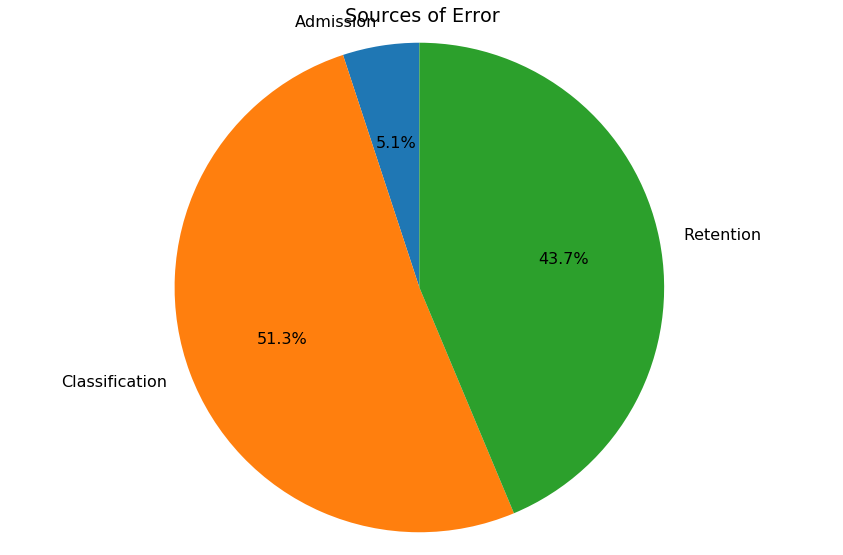

In [154]:
# Compare Sorces of Error
fig1, ax1 = plt.subplots()
ax1.pie(component_error, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
plt.title("Sources of Error")
ax1.axis('equal')  
plt.tight_layout()

## Final Model Prediction

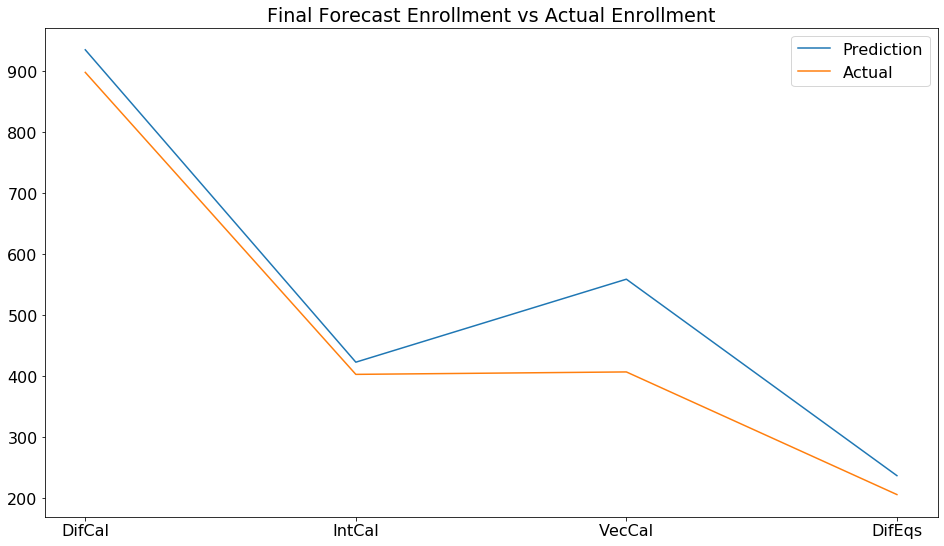

In [155]:
# Plot the Final Modle vs Actual Data
plt.figure(figsize=(16,9))
plt.plot(final.CrsEn,final.Final_Pred, label = 'Prediction')
plt.plot(final.CrsEn,final.S2_Enrolled, label = 'Actual')
plt.title("Final Forecast Enrollment vs Actual Enrollment")
plt.legend(loc="best");

## End